앞서 살펴본 LSTM 레이어를 이용하여 몇가지 순환 신경망 모델을 만들어보고, 각 모델에 "나비야" 동요를 학습시켜보면서 자세히 살펴보겠습니다.

---

### 시퀀스 데이터 준비

순환 신경망은 주로 자연어 처리에 많이 쓰이기 때문에 문장 학습 예제가 일반적이지만 본 강좌에서는 악보 학습을 해보겠습니다. 그 이유는 
- 음계가 문장보다 더 코드화 하기 쉽고, 
- 시계열 자료이며, 
- 나온 결과를 악보로 볼 수 있으며,
- 무엇보다 우리가 학습한 모델이 연주하는 곡을 들어볼 수 있기 때문입니다. 
일단 쉬운 악보인 '나비야'를 준비했습니다.

![img](http://tykimos.github.io/warehouse/2017-4-9-RNN_Layer_Talk_2.png)

음표 밑에 간단한 음표코드를 표시하였습니다. 알파벳은 음계를 나타내며, 숫자는 음의 길이를 나타냅니다.
- c(도), d(레), e(미), f(파), g(솔), a(라), b(시)
- 4(4분음표), 8(8분음표)

---

### 데이터셋 생성

먼저 두 마디만 살펴보겠습니다. 

* g8 e8 e4
* f8 d8 d4 

여기서 우리가 정의한 문제대로 4개 음표 입력으로 다음 출력 음표를 예측하려면, 아래와 같이 데이터셋을 구성합니다.

* g8 e8 e4 f8 d8 : 1~4번째 음표, 5번째 음표
* e8 e4 f8 d8 d4 : 2~5번째 음표, 6번째 음표

6개의 음표로는 위와 같이 2개의 샘플이 나옵니다. 각 샘플은 4개의 입력 데이터와 1개의 라벨값으로 구성되어 있습니다. 즉 1~4번째 열은 속성(feature)이고, 5번째 열은 클래스(class)를 나타냅니다. 이렇게 4개씩 구간을 보는 것을 윈도우 크기가 4라고 합니다. 그리고 문자와 숫자로 된 음표(코드)로는 모델 입출력으로 사용할 수 없기 때문에 각 코드를 숫자로 변환할 수 있는 사전을 하나 만들어봅니다. 첫번째 사전은 코드를 숫자로, 두번째 사전은 숫자를 코드로 만드는 코드입니다.

In [1]:
code2idx = {'c4':0, 'd4':1, 'e4':2, 'f4':3, 'g4':4, 'a4':5, 'b4':6,
            'c8':7, 'd8':8, 'e8':9, 'f8':10, 'g8':11, 'a8':12, 'b8':13}

idx2code = {0:'c4', 1:'d4', 2:'e4', 3:'f4', 4:'g4', 5:'a4', 6:'b4',
            7:'c8', 8:'d8', 9:'e8', 10:'f8', 11:'g8', 12:'a8', 13:'b8'}

이러한 사전을 이용해서 순차적인 음표를 우리가 지정한 윈도우 크기만큼 잘라 데이터셋을 생성하는 함수를 정의해보겠습니다.

In [2]:
import numpy as np

def seq2dataset(seq, window_size):
    dataset = []
    for i in range(len(seq)-window_size):
        subset = seq[i:(i+window_size+1)]
        dataset.append([code2idx[item] for item in subset])
    return np.array(dataset)

seq라는 변수에 "나비야" 곡 전체 음표를 저장한 다음, seq2dataset() 함수를 하여 dataset를 생성합니다. 데이터셋은 앞서 정의한 사전에 따라 숫자로 변환되어 생성됩니다.

In [3]:
seq = ['g8', 'e8', 'e4', 'f8', 'd8', 'd4', 'c8', 'd8', 'e8', 'f8', 'g8', 'g8', 'g4',
       'g8', 'e8', 'e8', 'e8', 'f8', 'd8', 'd4', 'c8', 'e8', 'g8', 'g8', 'e8', 'e8', 'e4',
       'd8', 'd8', 'd8', 'd8', 'd8', 'e8', 'f4', 'e8', 'e8', 'e8', 'e8', 'e8', 'f8', 'g4',
       'g8', 'e8', 'e4', 'f8', 'd8', 'd4', 'c8', 'e8', 'g8', 'g8', 'e8', 'e8', 'e4']

dataset = seq2dataset(seq, window_size = 4)

print(dataset.shape)
print(dataset)

(50, 5)
[[11  9  2 10  8]
 [ 9  2 10  8  1]
 [ 2 10  8  1  7]
 [10  8  1  7  8]
 [ 8  1  7  8  9]
 [ 1  7  8  9 10]
 [ 7  8  9 10 11]
 [ 8  9 10 11 11]
 [ 9 10 11 11  4]
 [10 11 11  4 11]
 [11 11  4 11  9]
 [11  4 11  9  9]
 [ 4 11  9  9  9]
 [11  9  9  9 10]
 [ 9  9  9 10  8]
 [ 9  9 10  8  1]
 [ 9 10  8  1  7]
 [10  8  1  7  9]
 [ 8  1  7  9 11]
 [ 1  7  9 11 11]
 [ 7  9 11 11  9]
 [ 9 11 11  9  9]
 [11 11  9  9  2]
 [11  9  9  2  8]
 [ 9  9  2  8  8]
 [ 9  2  8  8  8]
 [ 2  8  8  8  8]
 [ 8  8  8  8  8]
 [ 8  8  8  8  9]
 [ 8  8  8  9  3]
 [ 8  8  9  3  9]
 [ 8  9  3  9  9]
 [ 9  3  9  9  9]
 [ 3  9  9  9  9]
 [ 9  9  9  9  9]
 [ 9  9  9  9 10]
 [ 9  9  9 10  4]
 [ 9  9 10  4 11]
 [ 9 10  4 11  9]
 [10  4 11  9  2]
 [ 4 11  9  2 10]
 [11  9  2 10  8]
 [ 9  2 10  8  1]
 [ 2 10  8  1  7]
 [10  8  1  7  9]
 [ 8  1  7  9 11]
 [ 1  7  9 11 11]
 [ 7  9 11 11  9]
 [ 9 11 11  9  9]
 [11 11  9  9  2]]


---

### 학습 과정

"나비야"노래는 우리에게 너무나 익숙한 노래입니다. 만약 옆사람이 "나비야~ 나"까지만 불러도 나머지를 이어서 다 부를 수 있을 정도로 말이죠. 이렇게 첫 4개 음표를 입력하면 나머지를 연주할 수 있는 모델을 만드는 것이 목표입니다. 우리가 정의한 문제를 풀기 위해 먼저 모델을 학습시켜야 합니다. 학습 시키는 방식은 아래와 같습니다.

- 파란색 박스가 입력값이고, 빨간색 박스가 우리가 원하는 출력값입니다. 
- 1~4번째 음표를 데이터로 5번째 음표를 라벨값으로 학습을 시킵니다.
- 다음에는 2~5번째 음표를 데이터로 6번째 음표를 라벨값으로 학습을 시킵니다.
- 이후 한 음표씩 넘어가면서 노래 끝까지 학습시킵니다.

![img](http://tykimos.github.io/warehouse/2017-4-9-RNN_Layer_Talk_5.png)

---
### 예측 과정

예측은 두 가지 방법으로 해보겠습니다. `한 스텝 예측`과 `곡 전체 예측`입니다. 

#### 한 스텝 예측

한 스텝 예측이란 실제 음표 4개를 입력하여 다음 음표 1개를 예측하는 것을 반복하는 것입니다. 이 방법에서는 모델의 입력값으로는 항상 실제 음표가 들어갑니다.
- 모델에 t0, t1, t2, t3를 입력하면 y0 출력이 나옵니다. 
- 모델에 t1, t2, t3, t4를 입력하면 y1 출력이 나옵니다.
- 모델에 t2, t3, t4, t5를 입력하면 y2 출력이 나옵니다.
- 이 과정을 y49 출력까지 반복합니다. 

![img](http://tykimos.github.io/warehouse/2017-4-9-RNN_Layer_Talk_6.png)

#### 곡 전체 예측

곡 전체 예측이란 입력된 초가 4개 음표만을 입력으로 곡 전체를 예측하는 것입니다. 초반부가 지나면, 예측값만으로 모델에 입력되어 다음 예측값이 나오는 식입니다. 그야말로 "나비야~ 나"까지 알려주면 나머지까지 모두 연주를 하는 것이죠. 만약 중간에 틀린 부분이 생긴다면, 이후 음정, 박자는 모두 이상하게 될 가능성이 많습니다. 예측 오류가 누적되는 것이겠죠.

- 모델에 t0, t1, t2, t3를 입력하면 y0 출력이 나옵니다.
- 예측값인 y0를 t4라고 가정하고, 모델에 t1, t2, t3, t4을 입력하면 y1 출력이 나옵니다.
- 예측값인 y1을 t5라고 가정하고, 모델에 t2, t3, t4(예측값), t5(예측값)을 입력하면 y2 출력이 나옵니다.
- 이 과정을 y49 출력까지 반복합니다.

![img](http://tykimos.github.io/warehouse/2017-4-9-RNN_Layer_Talk_7.png)

---

### 다층 퍼셉트론 모델

앞서 생성한 데이터셋으로 먼저 다층 퍼셉트론 모델을 학습시켜보겠습니다. Dense 레이어 3개로 구성하였고, 입력 속성이 4개이고 출력이 12개(one_hot_vec_size=12)으로 설정했습니다.

In [ ]:
model = Sequential()
model.add(Dense(128, input_dim=4, activation='relu'))
model.add(Dense(128, activation='relu'))
model.add(Dense(one_hot_vec_size, activation='softmax'))

"나비야" 악보를 이 모델을 학습할 경우 다음 그림과 같이 수행됩니다. 4개의 음표를 입력으로 받고, 그 다음 음표가 라벨값으로 지정됩니다. 이 과정을 곡이 마칠 때까지 반복하게 됩니다.

![img](http://tykimos.github.io/warehouse/2017-4-9-RNN_Layer_Talk_train_MLP.png)

전체 소스는 다음과 같습니다.

Using TensorFlow backend.


(50, 5)
[[11  9  2 10  8]
 [ 9  2 10  8  1]
 [ 2 10  8  1  7]
 [10  8  1  7  8]
 [ 8  1  7  8  9]
 [ 1  7  8  9 10]
 [ 7  8  9 10 11]
 [ 8  9 10 11 11]
 [ 9 10 11 11  4]
 [10 11 11  4 11]
 [11 11  4 11  9]
 [11  4 11  9  9]
 [ 4 11  9  9  9]
 [11  9  9  9 10]
 [ 9  9  9 10  8]
 [ 9  9 10  8  1]
 [ 9 10  8  1  7]
 [10  8  1  7  9]
 [ 8  1  7  9 11]
 [ 1  7  9 11 11]
 [ 7  9 11 11  9]
 [ 9 11 11  9  9]
 [11 11  9  9  2]
 [11  9  9  2  8]
 [ 9  9  2  8  8]
 [ 9  2  8  8  8]
 [ 2  8  8  8  8]
 [ 8  8  8  8  8]
 [ 8  8  8  8  9]
 [ 8  8  8  9  3]
 [ 8  8  9  3  9]
 [ 8  9  3  9  9]
 [ 9  3  9  9  9]
 [ 3  9  9  9  9]
 [ 9  9  9  9  9]
 [ 9  9  9  9 10]
 [ 9  9  9 10  4]
 [ 9  9 10  4 11]
 [ 9 10  4 11  9]
 [10  4 11  9  2]
 [ 4 11  9  2 10]
 [11  9  2 10  8]
 [ 9  2 10  8  1]
 [ 2 10  8  1  7]
 [10  8  1  7  9]
 [ 8  1  7  9 11]
 [ 1  7  9 11 11]
 [ 7  9 11 11  9]
 [ 9 11 11  9  9]
 [11 11  9  9  2]]
('one hot encoding vector size is ', 12)
Epoch 1/2000
0s - loss: 2.4744 - acc: 0.1600
Epoch

0s - loss: 1.2571 - acc: 0.5400
Epoch 169/2000
0s - loss: 1.2558 - acc: 0.5600
Epoch 170/2000
0s - loss: 1.2564 - acc: 0.5400
Epoch 171/2000
0s - loss: 1.2533 - acc: 0.5400
Epoch 172/2000
0s - loss: 1.2515 - acc: 0.5400
Epoch 173/2000
0s - loss: 1.2407 - acc: 0.5600
Epoch 174/2000
0s - loss: 1.2400 - acc: 0.5600
Epoch 175/2000
0s - loss: 1.2436 - acc: 0.5600
Epoch 176/2000
0s - loss: 1.2362 - acc: 0.5600
Epoch 177/2000
0s - loss: 1.2317 - acc: 0.5600
Epoch 178/2000
0s - loss: 1.2340 - acc: 0.5400
Epoch 179/2000
0s - loss: 1.2344 - acc: 0.5600
Epoch 180/2000
0s - loss: 1.2265 - acc: 0.5600
Epoch 181/2000
0s - loss: 1.2281 - acc: 0.5600
Epoch 182/2000
0s - loss: 1.2269 - acc: 0.5400
Epoch 183/2000
0s - loss: 1.2254 - acc: 0.5600
Epoch 184/2000
0s - loss: 1.2215 - acc: 0.5600
Epoch 185/2000
0s - loss: 1.2203 - acc: 0.5600
Epoch 186/2000
0s - loss: 1.2184 - acc: 0.5400
Epoch 187/2000
0s - loss: 1.2123 - acc: 0.5400
Epoch 188/2000
0s - loss: 1.2145 - acc: 0.5400
Epoch 189/2000
0s - loss: 1.

0s - loss: 0.9682 - acc: 0.6000
Epoch 347/2000
0s - loss: 0.9697 - acc: 0.6000
Epoch 348/2000
0s - loss: 0.9776 - acc: 0.6200
Epoch 349/2000
0s - loss: 0.9609 - acc: 0.6000
Epoch 350/2000
0s - loss: 0.9625 - acc: 0.5600
Epoch 351/2000
0s - loss: 0.9618 - acc: 0.6000
Epoch 352/2000
0s - loss: 0.9713 - acc: 0.5600
Epoch 353/2000
0s - loss: 0.9634 - acc: 0.5600
Epoch 354/2000
0s - loss: 0.9659 - acc: 0.6000
Epoch 355/2000
0s - loss: 0.9636 - acc: 0.6000
Epoch 356/2000
0s - loss: 0.9667 - acc: 0.6000
Epoch 357/2000
0s - loss: 0.9588 - acc: 0.6200
Epoch 358/2000
0s - loss: 0.9567 - acc: 0.5800
Epoch 359/2000
0s - loss: 0.9535 - acc: 0.6200
Epoch 360/2000
0s - loss: 0.9544 - acc: 0.5600
Epoch 361/2000
0s - loss: 0.9497 - acc: 0.6000
Epoch 362/2000
0s - loss: 0.9519 - acc: 0.6200
Epoch 363/2000
0s - loss: 0.9503 - acc: 0.6200
Epoch 364/2000
0s - loss: 0.9503 - acc: 0.5600
Epoch 365/2000
0s - loss: 0.9487 - acc: 0.6200
Epoch 366/2000
0s - loss: 0.9413 - acc: 0.6200
Epoch 367/2000
0s - loss: 0.

0s - loss: 0.7860 - acc: 0.6800
Epoch 527/2000
0s - loss: 0.7817 - acc: 0.6800
Epoch 528/2000
0s - loss: 0.7854 - acc: 0.6800
Epoch 529/2000
0s - loss: 0.7838 - acc: 0.7000
Epoch 530/2000
0s - loss: 0.7884 - acc: 0.6600
Epoch 531/2000
0s - loss: 0.7813 - acc: 0.6800
Epoch 532/2000
0s - loss: 0.7830 - acc: 0.6600
Epoch 533/2000
0s - loss: 0.7899 - acc: 0.6400
Epoch 534/2000
0s - loss: 0.7806 - acc: 0.6600
Epoch 535/2000
0s - loss: 0.7768 - acc: 0.6800
Epoch 536/2000
0s - loss: 0.7792 - acc: 0.6800
Epoch 537/2000
0s - loss: 0.7817 - acc: 0.6600
Epoch 538/2000
0s - loss: 0.7956 - acc: 0.6600
Epoch 539/2000
0s - loss: 0.7671 - acc: 0.7000
Epoch 540/2000
0s - loss: 0.7875 - acc: 0.6800
Epoch 541/2000
0s - loss: 0.7763 - acc: 0.7000
Epoch 542/2000
0s - loss: 0.7710 - acc: 0.6800
Epoch 543/2000
0s - loss: 0.7772 - acc: 0.6800
Epoch 544/2000
0s - loss: 0.7690 - acc: 0.6800
Epoch 545/2000
0s - loss: 0.7746 - acc: 0.6800
Epoch 546/2000
0s - loss: 0.7689 - acc: 0.6800
Epoch 547/2000
0s - loss: 0.

0s - loss: 0.6402 - acc: 0.7600
Epoch 712/2000
0s - loss: 0.6278 - acc: 0.7600
Epoch 713/2000
0s - loss: 0.6422 - acc: 0.7400
Epoch 714/2000
0s - loss: 0.6393 - acc: 0.7400
Epoch 715/2000
0s - loss: 0.6319 - acc: 0.7800
Epoch 716/2000
0s - loss: 0.6318 - acc: 0.7800
Epoch 717/2000
0s - loss: 0.6295 - acc: 0.7200
Epoch 718/2000
0s - loss: 0.6308 - acc: 0.7200
Epoch 719/2000
0s - loss: 0.6288 - acc: 0.8000
Epoch 720/2000
0s - loss: 0.6262 - acc: 0.8200
Epoch 721/2000
0s - loss: 0.6203 - acc: 0.8200
Epoch 722/2000
0s - loss: 0.6285 - acc: 0.7800
Epoch 723/2000
0s - loss: 0.6278 - acc: 0.7400
Epoch 724/2000
0s - loss: 0.6233 - acc: 0.8000
Epoch 725/2000
0s - loss: 0.6229 - acc: 0.7800
Epoch 726/2000
0s - loss: 0.6136 - acc: 0.8000
Epoch 727/2000
0s - loss: 0.6293 - acc: 0.7400
Epoch 728/2000
0s - loss: 0.6262 - acc: 0.7600
Epoch 729/2000
0s - loss: 0.6309 - acc: 0.7600
Epoch 730/2000
0s - loss: 0.6183 - acc: 0.8000
Epoch 731/2000
0s - loss: 0.6186 - acc: 0.7800
Epoch 732/2000
0s - loss: 0.

0s - loss: 0.5059 - acc: 0.8600
Epoch 887/2000
0s - loss: 0.5073 - acc: 0.8400
Epoch 888/2000
0s - loss: 0.4981 - acc: 0.8600
Epoch 889/2000
0s - loss: 0.5026 - acc: 0.8800
Epoch 890/2000
0s - loss: 0.4968 - acc: 0.8600
Epoch 891/2000
0s - loss: 0.4972 - acc: 0.8400
Epoch 892/2000
0s - loss: 0.4999 - acc: 0.8600
Epoch 893/2000
0s - loss: 0.4961 - acc: 0.8800
Epoch 894/2000
0s - loss: 0.4954 - acc: 0.8600
Epoch 895/2000
0s - loss: 0.5009 - acc: 0.8600
Epoch 896/2000
0s - loss: 0.5018 - acc: 0.9000
Epoch 897/2000
0s - loss: 0.4951 - acc: 0.8800
Epoch 898/2000
0s - loss: 0.4964 - acc: 0.8800
Epoch 899/2000
0s - loss: 0.4968 - acc: 0.8800
Epoch 900/2000
0s - loss: 0.4938 - acc: 0.8600
Epoch 901/2000
0s - loss: 0.4938 - acc: 0.8600
Epoch 902/2000
0s - loss: 0.4858 - acc: 0.8800
Epoch 903/2000
0s - loss: 0.5031 - acc: 0.8600
Epoch 904/2000
0s - loss: 0.4857 - acc: 0.8600
Epoch 905/2000
0s - loss: 0.4919 - acc: 0.8800
Epoch 906/2000
0s - loss: 0.4929 - acc: 0.9000
Epoch 907/2000
0s - loss: 0.

0s - loss: 0.3953 - acc: 0.9000
Epoch 1067/2000
0s - loss: 0.3901 - acc: 0.9000
Epoch 1068/2000
0s - loss: 0.3954 - acc: 0.9000
Epoch 1069/2000
0s - loss: 0.3905 - acc: 0.9000
Epoch 1070/2000
0s - loss: 0.3925 - acc: 0.9000
Epoch 1071/2000
0s - loss: 0.3984 - acc: 0.8800
Epoch 1072/2000
0s - loss: 0.3920 - acc: 0.9200
Epoch 1073/2000
0s - loss: 0.3865 - acc: 0.9000
Epoch 1074/2000
0s - loss: 0.3852 - acc: 0.9000
Epoch 1075/2000
0s - loss: 0.3909 - acc: 0.9200
Epoch 1076/2000
0s - loss: 0.3834 - acc: 0.9200
Epoch 1077/2000
0s - loss: 0.3931 - acc: 0.9000
Epoch 1078/2000
0s - loss: 0.3864 - acc: 0.9000
Epoch 1079/2000
0s - loss: 0.3917 - acc: 0.9200
Epoch 1080/2000
0s - loss: 0.3905 - acc: 0.9000
Epoch 1081/2000
0s - loss: 0.3906 - acc: 0.9000
Epoch 1082/2000
0s - loss: 0.3856 - acc: 0.9000
Epoch 1083/2000
0s - loss: 0.3885 - acc: 0.9200
Epoch 1084/2000
0s - loss: 0.3797 - acc: 0.9200
Epoch 1085/2000
0s - loss: 0.4021 - acc: 0.9000
Epoch 1086/2000
0s - loss: 0.3834 - acc: 0.9000
Epoch 10

0s - loss: 0.3247 - acc: 0.9200
Epoch 1240/2000
0s - loss: 0.3258 - acc: 0.9200
Epoch 1241/2000
0s - loss: 0.3147 - acc: 0.9200
Epoch 1242/2000
0s - loss: 0.3224 - acc: 0.9000
Epoch 1243/2000
0s - loss: 0.3168 - acc: 0.9200
Epoch 1244/2000
0s - loss: 0.3142 - acc: 0.9200
Epoch 1245/2000
0s - loss: 0.3117 - acc: 0.9200
Epoch 1246/2000
0s - loss: 0.3199 - acc: 0.9000
Epoch 1247/2000
0s - loss: 0.3140 - acc: 0.9000
Epoch 1248/2000
0s - loss: 0.3178 - acc: 0.9000
Epoch 1249/2000
0s - loss: 0.3181 - acc: 0.9000
Epoch 1250/2000
0s - loss: 0.3156 - acc: 0.9000
Epoch 1251/2000
0s - loss: 0.3171 - acc: 0.9000
Epoch 1252/2000
0s - loss: 0.3194 - acc: 0.9200
Epoch 1253/2000
0s - loss: 0.3117 - acc: 0.9200
Epoch 1254/2000
0s - loss: 0.3101 - acc: 0.9200
Epoch 1255/2000
0s - loss: 0.3211 - acc: 0.9200
Epoch 1256/2000
0s - loss: 0.3125 - acc: 0.9200
Epoch 1257/2000
0s - loss: 0.3185 - acc: 0.9000
Epoch 1258/2000
0s - loss: 0.3125 - acc: 0.9200
Epoch 1259/2000
0s - loss: 0.3109 - acc: 0.9200
Epoch 12

Epoch 1414/2000
0s - loss: 0.2743 - acc: 0.9200
Epoch 1415/2000
0s - loss: 0.2705 - acc: 0.9000
Epoch 1416/2000
0s - loss: 0.2679 - acc: 0.9200
Epoch 1417/2000
0s - loss: 0.2675 - acc: 0.9200
Epoch 1418/2000
0s - loss: 0.2750 - acc: 0.9000
Epoch 1419/2000
0s - loss: 0.2621 - acc: 0.9000
Epoch 1420/2000
0s - loss: 0.2676 - acc: 0.9200
Epoch 1421/2000
0s - loss: 0.2732 - acc: 0.9200
Epoch 1422/2000
0s - loss: 0.2672 - acc: 0.9200
Epoch 1423/2000
0s - loss: 0.2661 - acc: 0.9200
Epoch 1424/2000
0s - loss: 0.2614 - acc: 0.9200
Epoch 1425/2000
0s - loss: 0.2702 - acc: 0.9000
Epoch 1426/2000
0s - loss: 0.2671 - acc: 0.9200
Epoch 1427/2000
0s - loss: 0.2703 - acc: 0.9200
Epoch 1428/2000
0s - loss: 0.2686 - acc: 0.9200
Epoch 1429/2000
0s - loss: 0.2645 - acc: 0.9200
Epoch 1430/2000
0s - loss: 0.2644 - acc: 0.9000
Epoch 1431/2000
0s - loss: 0.2606 - acc: 0.9000
Epoch 1432/2000
0s - loss: 0.2672 - acc: 0.9200
Epoch 1433/2000
0s - loss: 0.2651 - acc: 0.9000
Epoch 1434/2000
0s - loss: 0.2616 - acc:

0s - loss: 0.2330 - acc: 0.9000
Epoch 1596/2000
0s - loss: 0.2432 - acc: 0.9000
Epoch 1597/2000
0s - loss: 0.2445 - acc: 0.9200
Epoch 1598/2000
0s - loss: 0.2379 - acc: 0.9200
Epoch 1599/2000
0s - loss: 0.2255 - acc: 0.9200
Epoch 1600/2000
0s - loss: 0.2385 - acc: 0.9000
Epoch 1601/2000
0s - loss: 0.2359 - acc: 0.9200
Epoch 1602/2000
0s - loss: 0.2295 - acc: 0.9200
Epoch 1603/2000
0s - loss: 0.2332 - acc: 0.9000
Epoch 1604/2000
0s - loss: 0.2241 - acc: 0.9200
Epoch 1605/2000
0s - loss: 0.2348 - acc: 0.9200
Epoch 1606/2000
0s - loss: 0.2291 - acc: 0.9200
Epoch 1607/2000
0s - loss: 0.2334 - acc: 0.9000
Epoch 1608/2000
0s - loss: 0.2273 - acc: 0.9200
Epoch 1609/2000
0s - loss: 0.2305 - acc: 0.9200
Epoch 1610/2000
0s - loss: 0.2307 - acc: 0.9200
Epoch 1611/2000
0s - loss: 0.2306 - acc: 0.9200
Epoch 1612/2000
0s - loss: 0.2292 - acc: 0.9200
Epoch 1613/2000
0s - loss: 0.2217 - acc: 0.9200
Epoch 1614/2000
0s - loss: 0.2285 - acc: 0.9200
Epoch 1615/2000
0s - loss: 0.2259 - acc: 0.9200
Epoch 16

0s - loss: 0.2019 - acc: 0.9200
Epoch 1767/2000
0s - loss: 0.2110 - acc: 0.9000
Epoch 1768/2000
0s - loss: 0.2010 - acc: 0.9200
Epoch 1769/2000
0s - loss: 0.2084 - acc: 0.9200
Epoch 1770/2000
0s - loss: 0.2003 - acc: 0.9200
Epoch 1771/2000
0s - loss: 0.2022 - acc: 0.9200
Epoch 1772/2000
0s - loss: 0.2000 - acc: 0.9200
Epoch 1773/2000
0s - loss: 0.2063 - acc: 0.9200
Epoch 1774/2000
0s - loss: 0.2118 - acc: 0.9000
Epoch 1775/2000
0s - loss: 0.2076 - acc: 0.9000
Epoch 1776/2000
0s - loss: 0.2038 - acc: 0.9200
Epoch 1777/2000
0s - loss: 0.1987 - acc: 0.9200
Epoch 1778/2000
0s - loss: 0.2048 - acc: 0.9200
Epoch 1779/2000
0s - loss: 0.2010 - acc: 0.9200
Epoch 1780/2000
0s - loss: 0.2063 - acc: 0.9200
Epoch 1781/2000
0s - loss: 0.2019 - acc: 0.9200
Epoch 1782/2000
0s - loss: 0.2032 - acc: 0.9200
Epoch 1783/2000
0s - loss: 0.2026 - acc: 0.9200
Epoch 1784/2000
0s - loss: 0.1992 - acc: 0.9200
Epoch 1785/2000
0s - loss: 0.2041 - acc: 0.9200
Epoch 1786/2000
0s - loss: 0.2010 - acc: 0.9000
Epoch 17

Epoch 1938/2000
0s - loss: 0.1933 - acc: 0.9000
Epoch 1939/2000
0s - loss: 0.1898 - acc: 0.9200
Epoch 1940/2000
0s - loss: 0.1932 - acc: 0.9200
Epoch 1941/2000
0s - loss: 0.1853 - acc: 0.9200
Epoch 1942/2000
0s - loss: 0.1994 - acc: 0.8800
Epoch 1943/2000
0s - loss: 0.1858 - acc: 0.9000
Epoch 1944/2000
0s - loss: 0.1929 - acc: 0.9200
Epoch 1945/2000
0s - loss: 0.1904 - acc: 0.9200
Epoch 1946/2000
0s - loss: 0.1963 - acc: 0.9200
Epoch 1947/2000
0s - loss: 0.1920 - acc: 0.9000
Epoch 1948/2000
0s - loss: 0.1925 - acc: 0.9200
Epoch 1949/2000
0s - loss: 0.1912 - acc: 0.9200
Epoch 1950/2000
0s - loss: 0.1991 - acc: 0.9000
Epoch 1951/2000
0s - loss: 0.1821 - acc: 0.9200
Epoch 1952/2000
0s - loss: 0.1874 - acc: 0.9000
Epoch 1953/2000
0s - loss: 0.1854 - acc: 0.9000
Epoch 1954/2000
0s - loss: 0.1880 - acc: 0.9200
Epoch 1955/2000
0s - loss: 0.1860 - acc: 0.9000
Epoch 1956/2000
0s - loss: 0.1833 - acc: 0.9200
Epoch 1957/2000
0s - loss: 0.1908 - acc: 0.9200
Epoch 1958/2000
0s - loss: 0.1874 - acc:

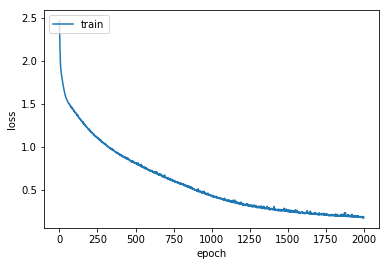

32/50 [==================>...........] - ETA: 0sacc: 92.00%
('one step prediction : ', ['g8', 'e8', 'e4', 'f8', 'd8', 'd4', 'c8', 'e8', 'e8', 'f8', 'g8', 'g8', 'g4', 'g8', 'e8', 'e8', 'e8', 'f8', 'd8', 'd4', 'c8', 'e8', 'g8', 'g8', 'e8', 'e8', 'e4', 'd8', 'd8', 'd8', 'd8', 'd8', 'd8', 'f4', 'e8', 'e8', 'e8', 'e8', 'e8', 'e8', 'd8', 'g8', 'e8', 'e4', 'f8', 'd8', 'd4', 'c8', 'e8', 'g8', 'g8', 'e8', 'e8', 'e4'])
('full song prediction : ', ['g8', 'e8', 'e4', 'f8', 'd8', 'd4', 'c8', 'e8', 'g8', 'g8', 'e8', 'e8', 'e4', 'd8', 'd8', 'd8', 'd8', 'd8', 'd8', 'd8', 'd8', 'd8', 'd8', 'd8', 'd8', 'd8', 'd8', 'd8', 'd8', 'd8', 'd8', 'd8', 'd8', 'd8', 'd8', 'd8', 'd8', 'd8', 'd8', 'd8', 'd8', 'd8', 'd8', 'd8', 'd8', 'd8', 'd8', 'd8', 'd8', 'd8', 'd8', 'd8', 'd8', 'd8'])


In [4]:
# 0. 사용할 패키지 불러오기
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.utils import np_utils
import numpy as np

# 랜덤시드 고정시키기
np.random.seed(5)

# 손실 이력 클래스 정의
class LossHistory(keras.callbacks.Callback):
    def init(self):
        self.losses = []
        
    def on_epoch_end(self, batch, logs={}):
        self.losses.append(logs.get('loss'))

# 데이터셋 생성 함수        
def seq2dataset(seq, window_size):
    dataset = []
    for i in range(len(seq)-window_size):
        subset = seq[i:(i+window_size+1)]
        dataset.append([code2idx[item] for item in subset])
    return np.array(dataset)

# 1. 데이터 준비하기

# 코드 사전 정의

code2idx = {'c4':0, 'd4':1, 'e4':2, 'f4':3, 'g4':4, 'a4':5, 'b4':6,
            'c8':7, 'd8':8, 'e8':9, 'f8':10, 'g8':11, 'a8':12, 'b8':13}

idx2code = {0:'c4', 1:'d4', 2:'e4', 3:'f4', 4:'g4', 5:'a4', 6:'b4',
            7:'c8', 8:'d8', 9:'e8', 10:'f8', 11:'g8', 12:'a8', 13:'b8'}

# 시퀀스 데이터 정의

seq = ['g8', 'e8', 'e4', 'f8', 'd8', 'd4', 'c8', 'd8', 'e8', 'f8', 'g8', 'g8', 'g4',
       'g8', 'e8', 'e8', 'e8', 'f8', 'd8', 'd4', 'c8', 'e8', 'g8', 'g8', 'e8', 'e8', 'e4',
       'd8', 'd8', 'd8', 'd8', 'd8', 'e8', 'f4', 'e8', 'e8', 'e8', 'e8', 'e8', 'f8', 'g4',
       'g8', 'e8', 'e4', 'f8', 'd8', 'd4', 'c8', 'e8', 'g8', 'g8', 'e8', 'e8', 'e4']

# 2. 데이터셋 생성하기
dataset = seq2dataset(seq, window_size = 4)

print(dataset.shape)
print(dataset)

# 입력(X)과 출력(Y) 변수로 분리하기
x_train = dataset[:,0:4]
y_train = dataset[:,4]

max_idx_value = 13

# 입력값 정규화 시키기
x_train = x_train / float(max_idx_value)

# 라벨값에 대한 one-hot 인코딩 수행
y_train = np_utils.to_categorical(y_train)

one_hot_vec_size = y_train.shape[1]

print("one hot encoding vector size is ", one_hot_vec_size)

# 3. 모델 구성하기
model = Sequential()
model.add(Dense(128, input_dim=4, activation='relu'))
model.add(Dense(128, activation='relu'))
model.add(Dense(one_hot_vec_size, activation='softmax'))

# 4. 모델 학습과정 설정하기
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

history = LossHistory() # 손실 이력 객체 생성
history.init()

# 5. 모델 학습시키기
model.fit(x_train, y_train, epochs=2000, batch_size=10, verbose=2, callbacks=[history])
    
# 6. 학습과정 살펴보기
%matplotlib inline
import matplotlib.pyplot as plt

plt.plot(history.losses)
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train'], loc='upper left')
plt.show()

# 7. 모델 평가하기
scores = model.evaluate(x_train, y_train)
print("%s: %.2f%%" %(model.metrics_names[1], scores[1]*100))

# 8. 모델 사용하기

pred_count = 50 # 최대 예측 개수 정의

# 한 스텝 예측

seq_out = ['g8', 'e8', 'e4', 'f8']
pred_out = model.predict(x_train)

for i in range(pred_count):
    idx = np.argmax(pred_out[i]) # one-hot 인코딩을 인덱스 값으로 변환
    seq_out.append(idx2code[idx]) # seq_out는 최종 악보이므로 인덱스 값을 코드로 변환하여 저장
    
print("one step prediction : ", seq_out)

# 곡 전체 예측

seq_in = ['g8', 'e8', 'e4', 'f8']
seq_out = seq_in
seq_in = [code2idx[it] / float(max_idx_value) for it in seq_in] # 코드를 인덱스값으로 변환

for i in range(pred_count):
    sample_in = np.array(seq_in)
    sample_in = np.reshape(sample_in, (1, 4)) # batch_size, feature
    pred_out = model.predict(sample_in)
    idx = np.argmax(pred_out)
    seq_out.append(idx2code[idx])
    seq_in.append(idx / float(max_idx_value))
    seq_in.pop(0)

print("full song prediction : ", seq_out)

한 스텝 예측 결과와 곡 전체 예측 결과를 악보로 그려보았습니다. 이 중 틀린 부분을 빨간색 박스로 표시해봤습니다. 총 50개 예측 중 4개가 틀려서 92%의 정확도가 나왔습니다. 중간에 틀린 부분이 생기면 곡 전체를 예측하는 데 있어서는 그리 좋은 성능이 나오지 않습니다.

![img](http://tykimos.github.io/warehouse/2017-4-9-RNN_Layer_Talk_MLP_song.png)

위 악보로 연주한 곡은 아래 링크에서 다운로드 받으실 수 있습니다.

* [http://tykimos.github.io/warehouse/2017-4-9-MLP_one_step_prediction.mp3](http://tykimos.github.io/warehouse/2017-4-9-MLP_one_step_prediction.mp3)
* [http://tykimos.github.io/warehouse/2017-4-9-MLP_full_song_prediction.mp3](http://tykimos.github.io/warehouse/2017-4-9-MLP_full_song_prediction.mp3)

---

### 기본 LSTM 모델

이번에는 간단한 기본 LSTM 모델로 먼저 테스트를 해보겠습니다. 모델 구성은 다음과 같이 하였습니다.
- 128 메모리 셀을 가진 LSTM 레이어 1개와 Dense 레이어로 구성
- 입력은 샘플이 50개, 타임스텝이 4개, 속성이 1개로 구성
- 상태유지(stateful) 모드 비활성화

케라스에서는 아래와 같이 LSTM을 구성할 수 있습니다.

In [ ]:
model = Sequential()
model.add(LSTM(128, input_shape = (4, 1)))
model.add(Dense(one_hot_vec_size, activation='softmax'))

LSTM을 제대로 활용하기 위해서는 `상태유지 모드`, `배치사이즈`, `타임스텝`, `속성`에 대한 개념에 이해가 필요합니다. 본 절에서는 `타임스텝`에 대해서 먼저 알아보겠습니다. `타임스텝`이란 하나의 샘플에 포함된 시퀀스 개수입니다. 이는 앞서 살펴본 "input_length"와 동일합니다. 현재 문제에서는 매 샘플마다 4개의 값을 입력하므로 타임스텝이 4개로 지정할 수 있습니다. 즉 윈도우 크기와 동일하게 타임스텝으로 설정하면 됩니다. `속성`에 대해서는 나중에 알아보겠지만, 입력되는 음표 1개당 하나의 인덱스 값을 입력하므로 속성이 1개입니다. 나중에 이 `속성`의 개수를 다르게 해서 테스트 해보겠습니다. 인자로 "input_shape = (4, 1)'과 "input_dim = 1, input_length = 4"는 동일합니다. 설정한 LSTM 모델에 따라 입력할 데이터셋도 샘플 수, 타임스텝 수, 속성 수 형식으로 맞추어야 합니다. 따라서 앞서 구성한 x_train를 아래와 같이 형식을 변환합니다.

In [ ]:
x_train = np.reshape(x_train, (50, 4, 1)) # 샘플 수, 타임스텝 수, 속성 수

이 모델로 악보를 학습할 경우, 다층 퍼셉트론 모델과 동일하게 4개의 음표를 입력으로 받고, 그 다음 음표가 라벨값으로 지정됩니다. 이 과정을 곡이 마칠 때까지 반복하게 됩니다. 다층 퍼셉트론 모델과 차이점이 있다면, 다층 퍼셉트론 모델에서는 4개의 음표가 4개의 속성으로 입력되고, LSTM에서는 4개의 음표가 4개의 시퀀스 입력으로 들어갑니다. 여기서 속성은 1개입니다.

![img](http://tykimos.github.io/warehouse/2017-4-9-RNN_Layer_Talk_train_LSTM.png)

전체 소스는 다음과 같습니다.

(50, 5)
('one hot encoding vector size is ', 12)
Epoch 1/2000
1s - loss: 2.4858 - acc: 0.1200
Epoch 2/2000
0s - loss: 2.4503 - acc: 0.2400
Epoch 3/2000
0s - loss: 2.4121 - acc: 0.3400
Epoch 4/2000
0s - loss: 2.3708 - acc: 0.3400
Epoch 5/2000
0s - loss: 2.3178 - acc: 0.3400
Epoch 6/2000
0s - loss: 2.2555 - acc: 0.3400
Epoch 7/2000
0s - loss: 2.1841 - acc: 0.3400
Epoch 8/2000
0s - loss: 2.1014 - acc: 0.3400
Epoch 9/2000
0s - loss: 2.0230 - acc: 0.3400
Epoch 10/2000
0s - loss: 1.9832 - acc: 0.3400
Epoch 11/2000
0s - loss: 1.9760 - acc: 0.3400
Epoch 12/2000
0s - loss: 1.9584 - acc: 0.3400
Epoch 13/2000
0s - loss: 1.9415 - acc: 0.3400
Epoch 14/2000
0s - loss: 1.9248 - acc: 0.3400
Epoch 15/2000
0s - loss: 1.9251 - acc: 0.3400
Epoch 16/2000
0s - loss: 1.9209 - acc: 0.3400
Epoch 17/2000
0s - loss: 1.9205 - acc: 0.3400
Epoch 18/2000
0s - loss: 1.9131 - acc: 0.3400
Epoch 19/2000
0s - loss: 1.9063 - acc: 0.3400
Epoch 20/2000
0s - loss: 1.9012 - acc: 0.3400
Epoch 21/2000
0s - loss: 1.9014 - acc: 0

0s - loss: 1.5610 - acc: 0.3600
Epoch 179/2000
0s - loss: 1.5487 - acc: 0.4200
Epoch 180/2000
0s - loss: 1.5437 - acc: 0.4400
Epoch 181/2000
0s - loss: 1.5441 - acc: 0.4400
Epoch 182/2000
0s - loss: 1.5433 - acc: 0.4800
Epoch 183/2000
0s - loss: 1.5366 - acc: 0.4800
Epoch 184/2000
0s - loss: 1.5387 - acc: 0.3800
Epoch 185/2000
0s - loss: 1.5640 - acc: 0.4000
Epoch 186/2000
0s - loss: 1.5338 - acc: 0.4400
Epoch 187/2000
0s - loss: 1.5453 - acc: 0.3800
Epoch 188/2000
0s - loss: 1.5492 - acc: 0.3800
Epoch 189/2000
0s - loss: 1.5220 - acc: 0.4400
Epoch 190/2000
0s - loss: 1.5580 - acc: 0.4200
Epoch 191/2000
0s - loss: 1.5368 - acc: 0.4600
Epoch 192/2000
0s - loss: 1.5328 - acc: 0.5000
Epoch 193/2000
0s - loss: 1.5238 - acc: 0.5000
Epoch 194/2000
0s - loss: 1.5105 - acc: 0.4800
Epoch 195/2000
0s - loss: 1.5142 - acc: 0.4600
Epoch 196/2000
0s - loss: 1.5184 - acc: 0.4800
Epoch 197/2000
0s - loss: 1.5044 - acc: 0.4200
Epoch 198/2000
0s - loss: 1.5055 - acc: 0.4200
Epoch 199/2000
0s - loss: 1.

0s - loss: 1.2400 - acc: 0.5400
Epoch 357/2000
0s - loss: 1.2458 - acc: 0.5200
Epoch 358/2000
0s - loss: 1.2313 - acc: 0.5200
Epoch 359/2000
0s - loss: 1.2164 - acc: 0.5000
Epoch 360/2000
0s - loss: 1.2191 - acc: 0.5200
Epoch 361/2000
0s - loss: 1.2271 - acc: 0.5000
Epoch 362/2000
0s - loss: 1.2206 - acc: 0.5200
Epoch 363/2000
0s - loss: 1.2163 - acc: 0.5800
Epoch 364/2000
0s - loss: 1.2139 - acc: 0.5600
Epoch 365/2000
0s - loss: 1.2122 - acc: 0.5400
Epoch 366/2000
0s - loss: 1.2044 - acc: 0.5800
Epoch 367/2000
0s - loss: 1.2119 - acc: 0.5600
Epoch 368/2000
0s - loss: 1.2151 - acc: 0.5200
Epoch 369/2000
0s - loss: 1.2137 - acc: 0.5000
Epoch 370/2000
0s - loss: 1.2023 - acc: 0.5200
Epoch 371/2000
0s - loss: 1.1995 - acc: 0.5200
Epoch 372/2000
0s - loss: 1.2089 - acc: 0.5000
Epoch 373/2000
0s - loss: 1.1903 - acc: 0.5200
Epoch 374/2000
0s - loss: 1.2349 - acc: 0.5600
Epoch 375/2000
0s - loss: 1.2281 - acc: 0.5400
Epoch 376/2000
0s - loss: 1.2096 - acc: 0.4600
Epoch 377/2000
0s - loss: 1.

0s - loss: 0.9223 - acc: 0.6600
Epoch 534/2000
0s - loss: 0.9220 - acc: 0.6600
Epoch 535/2000
0s - loss: 0.9320 - acc: 0.6200
Epoch 536/2000
0s - loss: 0.9186 - acc: 0.6400
Epoch 537/2000
0s - loss: 0.9276 - acc: 0.6400
Epoch 538/2000
0s - loss: 0.9266 - acc: 0.6400
Epoch 539/2000
0s - loss: 0.9113 - acc: 0.6000
Epoch 540/2000
0s - loss: 0.9511 - acc: 0.6200
Epoch 541/2000
0s - loss: 0.9185 - acc: 0.6200
Epoch 542/2000
0s - loss: 0.9393 - acc: 0.6200
Epoch 543/2000
0s - loss: 0.9397 - acc: 0.6200
Epoch 544/2000
0s - loss: 0.9219 - acc: 0.6200
Epoch 545/2000
0s - loss: 0.9385 - acc: 0.6400
Epoch 546/2000
0s - loss: 0.9120 - acc: 0.6600
Epoch 547/2000
0s - loss: 0.9145 - acc: 0.6200
Epoch 548/2000
0s - loss: 0.9322 - acc: 0.6000
Epoch 549/2000
0s - loss: 0.8904 - acc: 0.6800
Epoch 550/2000
0s - loss: 0.9019 - acc: 0.6400
Epoch 551/2000
0s - loss: 0.9132 - acc: 0.6000
Epoch 552/2000
0s - loss: 0.8950 - acc: 0.6400
Epoch 553/2000
0s - loss: 0.8885 - acc: 0.6000
Epoch 554/2000
0s - loss: 0.

0s - loss: 0.6635 - acc: 0.7600
Epoch 709/2000
0s - loss: 0.6644 - acc: 0.7800
Epoch 710/2000
0s - loss: 0.6796 - acc: 0.7800
Epoch 711/2000
0s - loss: 0.6738 - acc: 0.8000
Epoch 712/2000
0s - loss: 0.6849 - acc: 0.7600
Epoch 713/2000
0s - loss: 0.6404 - acc: 0.7800
Epoch 714/2000
0s - loss: 0.6617 - acc: 0.7200
Epoch 715/2000
0s - loss: 0.6623 - acc: 0.7600
Epoch 716/2000
0s - loss: 0.6490 - acc: 0.7600
Epoch 717/2000
0s - loss: 0.6406 - acc: 0.7800
Epoch 718/2000
0s - loss: 0.6503 - acc: 0.7800
Epoch 719/2000
0s - loss: 0.6374 - acc: 0.8000
Epoch 720/2000
0s - loss: 0.6540 - acc: 0.8400
Epoch 721/2000
0s - loss: 0.6446 - acc: 0.7600
Epoch 722/2000
0s - loss: 0.6390 - acc: 0.8000
Epoch 723/2000
0s - loss: 0.6377 - acc: 0.7600
Epoch 724/2000
0s - loss: 0.6335 - acc: 0.7400
Epoch 725/2000
0s - loss: 0.6368 - acc: 0.8000
Epoch 726/2000
0s - loss: 0.6399 - acc: 0.8200
Epoch 727/2000
0s - loss: 0.6425 - acc: 0.7600
Epoch 728/2000
0s - loss: 0.6423 - acc: 0.7800
Epoch 729/2000
0s - loss: 0.

0s - loss: 0.5286 - acc: 0.8400
Epoch 886/2000
0s - loss: 0.5237 - acc: 0.8200
Epoch 887/2000
0s - loss: 0.5366 - acc: 0.8200
Epoch 888/2000
0s - loss: 0.5051 - acc: 0.8600
Epoch 889/2000
0s - loss: 0.5103 - acc: 0.8600
Epoch 890/2000
0s - loss: 0.5126 - acc: 0.8200
Epoch 891/2000
0s - loss: 0.5444 - acc: 0.8200
Epoch 892/2000
0s - loss: 0.4882 - acc: 0.8200
Epoch 893/2000
0s - loss: 0.5479 - acc: 0.7800
Epoch 894/2000
0s - loss: 0.5217 - acc: 0.8200
Epoch 895/2000
0s - loss: 0.5210 - acc: 0.8200
Epoch 896/2000
0s - loss: 0.5108 - acc: 0.8200
Epoch 897/2000
0s - loss: 0.5243 - acc: 0.8000
Epoch 898/2000
0s - loss: 0.5201 - acc: 0.8000
Epoch 899/2000
0s - loss: 0.5075 - acc: 0.8200
Epoch 900/2000
0s - loss: 0.5665 - acc: 0.8000
Epoch 901/2000
0s - loss: 0.5198 - acc: 0.8000
Epoch 902/2000
0s - loss: 0.5428 - acc: 0.8000
Epoch 903/2000
0s - loss: 0.5320 - acc: 0.8000
Epoch 904/2000
0s - loss: 0.5126 - acc: 0.8200
Epoch 905/2000
0s - loss: 0.5239 - acc: 0.8600
Epoch 906/2000
0s - loss: 0.

Epoch 1060/2000
0s - loss: 0.4136 - acc: 0.8400
Epoch 1061/2000
0s - loss: 0.4459 - acc: 0.8400
Epoch 1062/2000
0s - loss: 0.4325 - acc: 0.8400
Epoch 1063/2000
0s - loss: 0.4317 - acc: 0.8400
Epoch 1064/2000
0s - loss: 0.4236 - acc: 0.8600
Epoch 1065/2000
0s - loss: 0.4301 - acc: 0.8400
Epoch 1066/2000
0s - loss: 0.4326 - acc: 0.8400
Epoch 1067/2000
0s - loss: 0.4285 - acc: 0.8200
Epoch 1068/2000
0s - loss: 0.4419 - acc: 0.8600
Epoch 1069/2000
0s - loss: 0.4423 - acc: 0.8400
Epoch 1070/2000
0s - loss: 0.4317 - acc: 0.8600
Epoch 1071/2000
0s - loss: 0.4458 - acc: 0.8600
Epoch 1072/2000
0s - loss: 0.4187 - acc: 0.8200
Epoch 1073/2000
0s - loss: 0.4248 - acc: 0.8600
Epoch 1074/2000
0s - loss: 0.4286 - acc: 0.8800
Epoch 1075/2000
0s - loss: 0.4390 - acc: 0.8400
Epoch 1076/2000
0s - loss: 0.4483 - acc: 0.8400
Epoch 1077/2000
0s - loss: 0.4476 - acc: 0.8600
Epoch 1078/2000
0s - loss: 0.4425 - acc: 0.8600
Epoch 1079/2000
0s - loss: 0.4582 - acc: 0.8200
Epoch 1080/2000
0s - loss: 0.4789 - acc:

0s - loss: 0.4316 - acc: 0.8600
Epoch 1232/2000
0s - loss: 0.3983 - acc: 0.8400
Epoch 1233/2000
0s - loss: 0.3871 - acc: 0.8400
Epoch 1234/2000
0s - loss: 0.3712 - acc: 0.8400
Epoch 1235/2000
0s - loss: 0.3760 - acc: 0.8800
Epoch 1236/2000
0s - loss: 0.3896 - acc: 0.8600
Epoch 1237/2000
0s - loss: 0.3743 - acc: 0.8400
Epoch 1238/2000
0s - loss: 0.3765 - acc: 0.8600
Epoch 1239/2000
0s - loss: 0.4086 - acc: 0.8600
Epoch 1240/2000
0s - loss: 0.3873 - acc: 0.8600
Epoch 1241/2000
0s - loss: 0.3818 - acc: 0.8600
Epoch 1242/2000
0s - loss: 0.4172 - acc: 0.8600
Epoch 1243/2000
0s - loss: 0.3819 - acc: 0.8400
Epoch 1244/2000
0s - loss: 0.3822 - acc: 0.8600
Epoch 1245/2000
0s - loss: 0.3755 - acc: 0.8600
Epoch 1246/2000
0s - loss: 0.3799 - acc: 0.8600
Epoch 1247/2000
0s - loss: 0.3846 - acc: 0.8600
Epoch 1248/2000
0s - loss: 0.3824 - acc: 0.8600
Epoch 1249/2000
0s - loss: 0.3983 - acc: 0.8400
Epoch 1250/2000
0s - loss: 0.3917 - acc: 0.8400
Epoch 1251/2000
0s - loss: 0.3799 - acc: 0.8800
Epoch 12

0s - loss: 0.3425 - acc: 0.8400
Epoch 1405/2000
0s - loss: 0.3675 - acc: 0.8800
Epoch 1406/2000
0s - loss: 0.3407 - acc: 0.8800
Epoch 1407/2000
0s - loss: 0.3479 - acc: 0.8200
Epoch 1408/2000
0s - loss: 0.3526 - acc: 0.8400
Epoch 1409/2000
0s - loss: 0.3265 - acc: 0.9000
Epoch 1410/2000
0s - loss: 0.3688 - acc: 0.8600
Epoch 1411/2000
0s - loss: 0.3839 - acc: 0.8400
Epoch 1412/2000
0s - loss: 0.3558 - acc: 0.8600
Epoch 1413/2000
0s - loss: 0.3629 - acc: 0.8600
Epoch 1414/2000
0s - loss: 0.3300 - acc: 0.8800
Epoch 1415/2000
0s - loss: 0.3720 - acc: 0.8600
Epoch 1416/2000
0s - loss: 0.3928 - acc: 0.8600
Epoch 1417/2000
0s - loss: 0.3483 - acc: 0.8600
Epoch 1418/2000
0s - loss: 0.3821 - acc: 0.8800
Epoch 1419/2000
0s - loss: 0.3756 - acc: 0.8400
Epoch 1420/2000
0s - loss: 0.3930 - acc: 0.8600
Epoch 1421/2000
0s - loss: 0.3489 - acc: 0.8600
Epoch 1422/2000
0s - loss: 0.3472 - acc: 0.8800
Epoch 1423/2000
0s - loss: 0.3659 - acc: 0.8600
Epoch 1424/2000
0s - loss: 0.3232 - acc: 0.8800
Epoch 14

0s - loss: 0.3155 - acc: 0.8600
Epoch 1576/2000
0s - loss: 0.3451 - acc: 0.8600
Epoch 1577/2000
0s - loss: 0.3085 - acc: 0.8600
Epoch 1578/2000
0s - loss: 0.3230 - acc: 0.8600
Epoch 1579/2000
0s - loss: 0.3308 - acc: 0.9000
Epoch 1580/2000
0s - loss: 0.3378 - acc: 0.8400
Epoch 1581/2000
0s - loss: 0.3260 - acc: 0.8400
Epoch 1582/2000
0s - loss: 0.3456 - acc: 0.8600
Epoch 1583/2000
0s - loss: 0.3243 - acc: 0.8600
Epoch 1584/2000
0s - loss: 0.3525 - acc: 0.8600
Epoch 1585/2000
0s - loss: 0.3392 - acc: 0.8600
Epoch 1586/2000
0s - loss: 0.3310 - acc: 0.8600
Epoch 1587/2000
0s - loss: 0.3214 - acc: 0.8600
Epoch 1588/2000
0s - loss: 0.3195 - acc: 0.8800
Epoch 1589/2000
0s - loss: 0.3227 - acc: 0.8800
Epoch 1590/2000
0s - loss: 0.3156 - acc: 0.8800
Epoch 1591/2000
0s - loss: 0.3091 - acc: 0.8800
Epoch 1592/2000
0s - loss: 0.3365 - acc: 0.8800
Epoch 1593/2000
0s - loss: 0.3013 - acc: 0.8600
Epoch 1594/2000
0s - loss: 0.3534 - acc: 0.8400
Epoch 1595/2000
0s - loss: 0.3331 - acc: 0.8800
Epoch 15

Epoch 1746/2000
0s - loss: 0.3014 - acc: 0.8600
Epoch 1747/2000
0s - loss: 0.3187 - acc: 0.8800
Epoch 1748/2000
0s - loss: 0.3014 - acc: 0.8800
Epoch 1749/2000
0s - loss: 0.3103 - acc: 0.8800
Epoch 1750/2000
0s - loss: 0.2986 - acc: 0.8600
Epoch 1751/2000
0s - loss: 0.3058 - acc: 0.8800
Epoch 1752/2000
0s - loss: 0.3000 - acc: 0.8800
Epoch 1753/2000
0s - loss: 0.3016 - acc: 0.8800
Epoch 1754/2000
0s - loss: 0.2947 - acc: 0.8800
Epoch 1755/2000
0s - loss: 0.3068 - acc: 0.8600
Epoch 1756/2000
0s - loss: 0.3094 - acc: 0.8800
Epoch 1757/2000
0s - loss: 0.2975 - acc: 0.9000
Epoch 1758/2000
0s - loss: 0.3157 - acc: 0.8800
Epoch 1759/2000
0s - loss: 0.2946 - acc: 0.9000
Epoch 1760/2000
0s - loss: 0.3327 - acc: 0.8600
Epoch 1761/2000
0s - loss: 0.3277 - acc: 0.8800
Epoch 1762/2000
0s - loss: 0.3674 - acc: 0.8600
Epoch 1763/2000
0s - loss: 0.4222 - acc: 0.7800
Epoch 1764/2000
0s - loss: 0.3134 - acc: 0.8600
Epoch 1765/2000
0s - loss: 0.3476 - acc: 0.8400
Epoch 1766/2000
0s - loss: 0.3259 - acc:

Epoch 1919/2000
0s - loss: 0.3189 - acc: 0.8400
Epoch 1920/2000
0s - loss: 0.2819 - acc: 0.8800
Epoch 1921/2000
0s - loss: 0.3587 - acc: 0.8600
Epoch 1922/2000
0s - loss: 0.3613 - acc: 0.8600
Epoch 1923/2000
0s - loss: 0.3529 - acc: 0.8400
Epoch 1924/2000
0s - loss: 0.3450 - acc: 0.8800
Epoch 1925/2000
0s - loss: 0.3343 - acc: 0.8600
Epoch 1926/2000
0s - loss: 0.3206 - acc: 0.8800
Epoch 1927/2000
0s - loss: 0.3208 - acc: 0.8800
Epoch 1928/2000
0s - loss: 0.3521 - acc: 0.8600
Epoch 1929/2000
0s - loss: 0.3050 - acc: 0.8600
Epoch 1930/2000
0s - loss: 0.2906 - acc: 0.9000
Epoch 1931/2000
0s - loss: 0.2992 - acc: 0.8800
Epoch 1932/2000
0s - loss: 0.2895 - acc: 0.8600
Epoch 1933/2000
0s - loss: 0.2964 - acc: 0.8800
Epoch 1934/2000
0s - loss: 0.2890 - acc: 0.8800
Epoch 1935/2000
0s - loss: 0.2973 - acc: 0.8800
Epoch 1936/2000
0s - loss: 0.2873 - acc: 0.9000
Epoch 1937/2000
0s - loss: 0.3030 - acc: 0.8800
Epoch 1938/2000
0s - loss: 0.2881 - acc: 0.8800
Epoch 1939/2000
0s - loss: 0.2836 - acc:

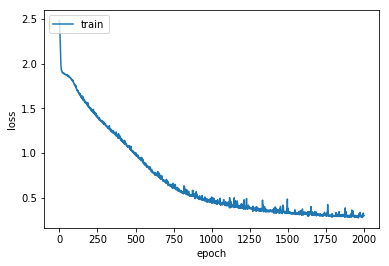

32/50 [==================>...........] - ETA: 0sacc: 90.00%
('one step prediction : ', ['g8', 'e8', 'e4', 'f8', 'd8', 'd4', 'c8', 'e8', 'g8', 'f8', 'g8', 'g8', 'g4', 'g8', 'e8', 'e8', 'e8', 'f8', 'g4', 'd4', 'c8', 'e8', 'g8', 'g8', 'e8', 'e8', 'e4', 'd8', 'd8', 'd8', 'd8', 'd8', 'd8', 'f4', 'e8', 'e8', 'e8', 'e8', 'f8', 'f8', 'g4', 'g8', 'e8', 'e4', 'f8', 'd8', 'd4', 'c8', 'e8', 'g8', 'g8', 'e8', 'e8', 'e4'])
('full song prediction : ', ['g8', 'e8', 'e4', 'f8', 'd8', 'd4', 'c8', 'e8', 'g8', 'g8', 'e8', 'e8', 'e4', 'd8', 'd8', 'd8', 'd8', 'd8', 'd8', 'd8', 'd8', 'd8', 'd8', 'd8', 'd8', 'd8', 'd8', 'd8', 'd8', 'd8', 'd8', 'd8', 'd8', 'd8', 'd8', 'd8', 'd8', 'd8', 'd8', 'd8', 'd8', 'd8', 'd8', 'd8', 'd8', 'd8', 'd8', 'd8', 'd8', 'd8', 'd8', 'd8', 'd8', 'd8'])


In [5]:
# 0. 사용할 패키지 불러오기
import keras
import numpy as np
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.utils import np_utils

# 랜덤시드 고정시키기
np.random.seed(5)

# 손실 이력 클래스 정의
class LossHistory(keras.callbacks.Callback):
    def init(self):
        self.losses = []
        
    def on_epoch_end(self, batch, logs={}):
        self.losses.append(logs.get('loss'))

# 데이터셋 생성 함수
def seq2dataset(seq, window_size):
    dataset = []
    for i in range(len(seq)-window_size):
        subset = seq[i:(i+window_size+1)]
        dataset.append([code2idx[item] for item in subset])
    return np.array(dataset)

# 1. 데이터 준비하기
        
# 코드 사전 정의

code2idx = {'c4':0, 'd4':1, 'e4':2, 'f4':3, 'g4':4, 'a4':5, 'b4':6,
            'c8':7, 'd8':8, 'e8':9, 'f8':10, 'g8':11, 'a8':12, 'b8':13}

idx2code = {0:'c4', 1:'d4', 2:'e4', 3:'f4', 4:'g4', 5:'a4', 6:'b4',
            7:'c8', 8:'d8', 9:'e8', 10:'f8', 11:'g8', 12:'a8', 13:'b8'}

# 시퀀스 데이터 정의

seq = ['g8', 'e8', 'e4', 'f8', 'd8', 'd4', 'c8', 'd8', 'e8', 'f8', 'g8', 'g8', 'g4',
       'g8', 'e8', 'e8', 'e8', 'f8', 'd8', 'd4', 'c8', 'e8', 'g8', 'g8', 'e8', 'e8', 'e4',
       'd8', 'd8', 'd8', 'd8', 'd8', 'e8', 'f4', 'e8', 'e8', 'e8', 'e8', 'e8', 'f8', 'g4',
       'g8', 'e8', 'e4', 'f8', 'd8', 'd4', 'c8', 'e8', 'g8', 'g8', 'e8', 'e8', 'e4']

# 2. 데이터셋 생성하기

dataset = seq2dataset(seq, window_size = 4)

print(dataset.shape)

# 입력(X)과 출력(Y) 변수로 분리하기
x_train = dataset[:,0:4]
y_train = dataset[:,4]

max_idx_value = 13

# 입력값 정규화 시키기
x_train = x_train / float(max_idx_value)

# 입력을 (샘플 수, 타입스텝, 특성 수)로 형태 변환
x_train = np.reshape(x_train, (50, 4, 1))

# 라벨값에 대한 one-hot 인코딩 수행
y_train = np_utils.to_categorical(y_train)

one_hot_vec_size = y_train.shape[1]

print("one hot encoding vector size is ", one_hot_vec_size)

# 3. 모델 구성하기
model = Sequential()
model.add(LSTM(128, input_shape = (4, 1)))
model.add(Dense(one_hot_vec_size, activation='softmax'))

# 4. 모델 학습과정 설정하기
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

history = LossHistory() # 손실 이력 객체 생성
history.init()

# 5. 모델 학습시키기
model.fit(x_train, y_train, epochs=2000, batch_size=14, verbose=2, callbacks=[history])

# 6. 학습과정 살펴보기
%matplotlib inline
import matplotlib.pyplot as plt

plt.plot(history.losses)
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train'], loc='upper left')
plt.show()

# 7. 모델 평가하기
scores = model.evaluate(x_train, y_train)
print("%s: %.2f%%" %(model.metrics_names[1], scores[1]*100))

# 8. 모델 사용하기

pred_count = 50 # 최대 예측 개수 정의

# 한 스텝 예측

seq_out = ['g8', 'e8', 'e4', 'f8']
pred_out = model.predict(x_train)

for i in range(pred_count):
    idx = np.argmax(pred_out[i]) # one-hot 인코딩을 인덱스 값으로 변환
    seq_out.append(idx2code[idx]) # seq_out는 최종 악보이므로 인덱스 값을 코드로 변환하여 저장
    
print("one step prediction : ", seq_out)

# 곡 전체 예측

seq_in = ['g8', 'e8', 'e4', 'f8']
seq_out = seq_in
seq_in = [code2idx[it] / float(max_idx_value) for it in seq_in] # 코드를 인덱스값으로 변환

for i in range(pred_count):
    sample_in = np.array(seq_in)
    sample_in = np.reshape(sample_in, (1, 4, 1)) # 샘플 수, 타입스텝 수, 속성 수
    pred_out = model.predict(sample_in)
    idx = np.argmax(pred_out)
    seq_out.append(idx2code[idx])
    seq_in.append(idx / float(max_idx_value))
    seq_in.pop(0)

print("full song prediction : ", seq_out)

한 스텝 예측 결과와 곡 전체 예측 결과를 악보로 그려보았습니다. 이 중 틀린 부분을 빨간색 박스로 표시해봤습니다. 총 50개 예측 중 4개가 틀려서 92%의 정확도가 나왔습니다. 중간에 틀릭 부분이 생기면 곡 전체를 예측하는 데 있어서는 그리 좋은 성능이 나오지 않습니다.

![img](http://tykimos.github.io/warehouse/2017-4-9-RNN_Layer_Talk_LSTM_song.png)

위 악보로 연주한 곡은 아래 링크에서 다운로드 받으실 수 있습니다.

* [http://tykimos.github.io/warehouse/2017-4-9-Stateless_LSTM_one_step_prediction.mp3](http://tykimos.github.io/warehouse/2017-4-9-Stateless_LSTM_one_step_prediction.mp3)
* [http://tykimos.github.io/warehouse/2017-4-9-Stateless_LSTM_full_song_prediction.mp3](http://tykimos.github.io/warehouse/2017-4-9-Stateless_LSTM_full_song_prediction.mp3)

---

### 상태유지 LSTM 모델

이번에는 상태유지(Stateful) LSTM 모델에 대해서 알아보겠습니다. 여기서 `상태유지`라는 것은 현재 학습된 상태가 다음 학습 시 초기 상태로 전달된다는 것을 의미합니다. 

    상태유지 모드에서는 현재 샘플의 학습 상태가 다음 샘플의 초기 상태로 전달된다.
    
긴 시퀀드 데이터를 처리할 때, LSTM 모델은 상태유지 모드에서 그 진가를 발휘합니다. 긴 시퀀스 데이터를 샘플 단위로 잘라서 학습하더라도 LSTM 내부적으로 기억할 것은 기억하고 버릴 것은 버려서 기억해야할 중요한 정보만 이어갈 수 있도록 상태가 유지되기 때문입니다. 상태유지 LSTM 모델을 생성하기 위해서는 LSTM 레이어 생성 시, stateful=True로 설정하면 됩니다. 또한 상태유지 모드에서는 입력형태를 batch_input_shape = (배치사이즈, 타임스텝, 속성)으로 설정해야 합니다. 상태유지 모드에서 배치사이즈 개념은 조금 어려우므로 다음 장에서 다루기로 하겠습니다. 

In [ ]:
model = Sequential()
model.add(LSTM(128, batch_input_shape = (1, 4, 1), stateful=True))
model.add(Dense(one_hot_vec_size, activation='softmax'))

상태유지 모드에서는 모델 학습 시에 `상태 초기화`에 대한 고민이 필요합니다. 현재 샘플 학습 상태가 다음 샘플 학습의 초기상태로 전달되는 식인데, 현재 샘플과 다음 샘플 간의 순차적인 관계가 없을 경우에는 상태가 유지되지 않고 초기화가 되어야 합니다. 다음 상황이 이러한 경우에 해당됩니다.

- 마지막 샘플 학습이 마치고, 새로운 에포크 수행 시에는 새로운 샘플 학습을 해야하므로 상태 초기화 필요
- 한 에포크 안에 여러 시퀀스 데이터 세트가 있을 경우, 새로운 시퀀스 데이터 세트를 학습 전에 상태 초기화 필요

현재 코드에서는 한 곡을 가지고 계속 학습을 시키고 있으므로 새로운 에포크 시작 시에만 상태 초기화를 수행하면 됩니다.

In [ ]:
num_epochs = 2000

for epoch_idx in range(num_epochs):
    print ('epochs : ' + str(epoch_idx) )
    model.fit(x_train, y_train, epochs=1, batch_size=1, verbose=2, shuffle=False) # 50 is X.shape[0]
    model.reset_states()

아래 그림은 이 모델로 악보를 학습할 경우를 나타낸 것입니다. 거의 기본 LSTM 모델과 동일하지만 학습된 상태가 다음 샘플 학습 시에 초기 상태로 입력되는 것을 보실 수 있습니다.

![img](http://tykimos.github.io/warehouse/2017-4-9-RNN_Layer_Talk_train_stateful_LSTM.png)

전체 소스는 다음과 같습니다.

(50, 5)
('one hot encoding vector size is ', 12)
epochs : 0
Epoch 1/1
1s - loss: 2.3485 - acc: 0.1400
epochs : 1
Epoch 1/1
0s - loss: 2.0415 - acc: 0.3400
epochs : 2
Epoch 1/1
0s - loss: 1.9635 - acc: 0.3400
epochs : 3
Epoch 1/1
0s - loss: 1.9469 - acc: 0.3400
epochs : 4
Epoch 1/1
0s - loss: 1.9369 - acc: 0.3400
epochs : 5
Epoch 1/1
0s - loss: 1.9301 - acc: 0.3400
epochs : 6
Epoch 1/1
0s - loss: 1.9248 - acc: 0.3600
epochs : 7
Epoch 1/1
0s - loss: 1.9205 - acc: 0.3600
epochs : 8
Epoch 1/1
0s - loss: 1.9168 - acc: 0.3600
epochs : 9
Epoch 1/1
0s - loss: 1.9134 - acc: 0.3600
epochs : 10
Epoch 1/1
0s - loss: 1.9102 - acc: 0.3600
epochs : 11
Epoch 1/1
0s - loss: 1.9070 - acc: 0.3600
epochs : 12
Epoch 1/1
0s - loss: 1.9036 - acc: 0.3600
epochs : 13
Epoch 1/1
0s - loss: 1.8998 - acc: 0.3600
epochs : 14
Epoch 1/1
0s - loss: 1.8954 - acc: 0.3600
epochs : 15
Epoch 1/1
0s - loss: 1.9070 - acc: 0.3600
epochs : 16
Epoch 1/1
0s - loss: 1.8937 - acc: 0.3600
epochs : 17
Epoch 1/1
0s - loss: 1.8827 - a

0s - loss: 0.4471 - acc: 0.8200
epochs : 151
Epoch 1/1
0s - loss: 0.4395 - acc: 0.8400
epochs : 152
Epoch 1/1
0s - loss: 0.9733 - acc: 0.6600
epochs : 153
Epoch 1/1
0s - loss: 0.4066 - acc: 0.8600
epochs : 154
Epoch 1/1
0s - loss: 0.4102 - acc: 0.8600
epochs : 155
Epoch 1/1
0s - loss: 0.4537 - acc: 0.8400
epochs : 156
Epoch 1/1
0s - loss: 0.6009 - acc: 0.7000
epochs : 157
Epoch 1/1
0s - loss: 0.5479 - acc: 0.8600
epochs : 158
Epoch 1/1
0s - loss: 0.3718 - acc: 0.9200
epochs : 159
Epoch 1/1
0s - loss: 0.2549 - acc: 0.9400
epochs : 160
Epoch 1/1
0s - loss: 0.3066 - acc: 0.8800
epochs : 161
Epoch 1/1
0s - loss: 0.2699 - acc: 0.9000
epochs : 162
Epoch 1/1
0s - loss: 0.2508 - acc: 0.9200
epochs : 163
Epoch 1/1
0s - loss: 0.1692 - acc: 0.9600
epochs : 164
Epoch 1/1
0s - loss: 0.4645 - acc: 0.8400
epochs : 165
Epoch 1/1
0s - loss: 0.4173 - acc: 0.8400
epochs : 166
Epoch 1/1
0s - loss: 0.4026 - acc: 0.9000
epochs : 167
Epoch 1/1
0s - loss: 0.5119 - acc: 0.8200
epochs : 168
Epoch 1/1
0s - loss:

0s - loss: 0.0024 - acc: 1.0000
epochs : 300
Epoch 1/1
0s - loss: 0.0023 - acc: 1.0000
epochs : 301
Epoch 1/1
0s - loss: 0.0022 - acc: 1.0000
epochs : 302
Epoch 1/1
0s - loss: 0.0021 - acc: 1.0000
epochs : 303
Epoch 1/1
0s - loss: 0.0020 - acc: 1.0000
epochs : 304
Epoch 1/1
0s - loss: 0.0020 - acc: 1.0000
epochs : 305
Epoch 1/1
0s - loss: 0.0019 - acc: 1.0000
epochs : 306
Epoch 1/1
0s - loss: 0.0018 - acc: 1.0000
epochs : 307
Epoch 1/1
0s - loss: 0.0018 - acc: 1.0000
epochs : 308
Epoch 1/1
0s - loss: 0.0017 - acc: 1.0000
epochs : 309
Epoch 1/1
0s - loss: 0.0017 - acc: 1.0000
epochs : 310
Epoch 1/1
0s - loss: 0.0016 - acc: 1.0000
epochs : 311
Epoch 1/1
0s - loss: 0.0016 - acc: 1.0000
epochs : 312
Epoch 1/1
0s - loss: 0.0015 - acc: 1.0000
epochs : 313
Epoch 1/1
0s - loss: 0.0015 - acc: 1.0000
epochs : 314
Epoch 1/1
0s - loss: 0.0014 - acc: 1.0000
epochs : 315
Epoch 1/1
0s - loss: 0.0014 - acc: 1.0000
epochs : 316
Epoch 1/1
0s - loss: 0.0013 - acc: 1.0000
epochs : 317
Epoch 1/1
0s - loss:

0s - loss: 0.5299 - acc: 0.9000
epochs : 443
Epoch 1/1
0s - loss: 0.4882 - acc: 0.8200
epochs : 444
Epoch 1/1
0s - loss: 0.4622 - acc: 0.8600
epochs : 445
Epoch 1/1
0s - loss: 0.4000 - acc: 0.8800
epochs : 446
Epoch 1/1
0s - loss: 0.3224 - acc: 0.8800
epochs : 447
Epoch 1/1
0s - loss: 0.4514 - acc: 0.8000
epochs : 448
Epoch 1/1
0s - loss: 0.4989 - acc: 0.7600
epochs : 449
Epoch 1/1
0s - loss: 0.5636 - acc: 0.8200
epochs : 450
Epoch 1/1
0s - loss: 0.3440 - acc: 0.8600
epochs : 451
Epoch 1/1
0s - loss: 0.3463 - acc: 0.8400
epochs : 452
Epoch 1/1
0s - loss: 0.2269 - acc: 0.9400
epochs : 453
Epoch 1/1
0s - loss: 0.1976 - acc: 0.9600
epochs : 454
Epoch 1/1
0s - loss: 0.1188 - acc: 0.9800
epochs : 455
Epoch 1/1
0s - loss: 0.0795 - acc: 0.9800
epochs : 456
Epoch 1/1
0s - loss: 0.1606 - acc: 0.9600
epochs : 457
Epoch 1/1
0s - loss: 0.0976 - acc: 1.0000
epochs : 458
Epoch 1/1
0s - loss: 0.1538 - acc: 0.9600
epochs : 459
Epoch 1/1
0s - loss: 0.1670 - acc: 0.9800
epochs : 460
Epoch 1/1
0s - loss:

0s - loss: 2.7820e-04 - acc: 1.0000
epochs : 590
Epoch 1/1
0s - loss: 2.7045e-04 - acc: 1.0000
epochs : 591
Epoch 1/1
0s - loss: 2.6299e-04 - acc: 1.0000
epochs : 592
Epoch 1/1
0s - loss: 2.5566e-04 - acc: 1.0000
epochs : 593
Epoch 1/1
0s - loss: 2.4826e-04 - acc: 1.0000
epochs : 594
Epoch 1/1
0s - loss: 2.4087e-04 - acc: 1.0000
epochs : 595
Epoch 1/1
0s - loss: 2.3387e-04 - acc: 1.0000
epochs : 596
Epoch 1/1
0s - loss: 2.2712e-04 - acc: 1.0000
epochs : 597
Epoch 1/1
0s - loss: 2.2059e-04 - acc: 1.0000
epochs : 598
Epoch 1/1
0s - loss: 2.1425e-04 - acc: 1.0000
epochs : 599
Epoch 1/1
0s - loss: 2.0839e-04 - acc: 1.0000
epochs : 600
Epoch 1/1
0s - loss: 2.0283e-04 - acc: 1.0000
epochs : 601
Epoch 1/1
0s - loss: 1.9825e-04 - acc: 1.0000
epochs : 602
Epoch 1/1
0s - loss: 1.9340e-04 - acc: 1.0000
epochs : 603
Epoch 1/1
0s - loss: 1.8868e-04 - acc: 1.0000
epochs : 604
Epoch 1/1
0s - loss: 1.8395e-04 - acc: 1.0000
epochs : 605
Epoch 1/1
0s - loss: 1.7988e-04 - acc: 1.0000
epochs : 606
Epoch 1

0s - loss: 0.2609 - acc: 0.9400
epochs : 730
Epoch 1/1
0s - loss: 0.1786 - acc: 0.9400
epochs : 731
Epoch 1/1
0s - loss: 0.1426 - acc: 0.9600
epochs : 732
Epoch 1/1
0s - loss: 0.1709 - acc: 0.9800
epochs : 733
Epoch 1/1
0s - loss: 0.1943 - acc: 0.9400
epochs : 734
Epoch 1/1
0s - loss: 0.1161 - acc: 1.0000
epochs : 735
Epoch 1/1
0s - loss: 0.7321 - acc: 0.7200
epochs : 736
Epoch 1/1
0s - loss: 0.6264 - acc: 0.7600
epochs : 737
Epoch 1/1
0s - loss: 0.4656 - acc: 0.8200
epochs : 738
Epoch 1/1
0s - loss: 1.0026 - acc: 0.6400
epochs : 739
Epoch 1/1
0s - loss: 0.8632 - acc: 0.7200
epochs : 740
Epoch 1/1
0s - loss: 0.5637 - acc: 0.7600
epochs : 741
Epoch 1/1
0s - loss: 0.1957 - acc: 0.9200
epochs : 742
Epoch 1/1
0s - loss: 0.1242 - acc: 1.0000
epochs : 743
Epoch 1/1
0s - loss: 0.1195 - acc: 0.9800
epochs : 744
Epoch 1/1
0s - loss: 0.5812 - acc: 0.7800
epochs : 745
Epoch 1/1
0s - loss: 0.6361 - acc: 0.7400
epochs : 746
Epoch 1/1
0s - loss: 0.2450 - acc: 0.9200
epochs : 747
Epoch 1/1
0s - loss:

0s - loss: 1.8041e-04 - acc: 1.0000
epochs : 875
Epoch 1/1
0s - loss: 1.7719e-04 - acc: 1.0000
epochs : 876
Epoch 1/1
0s - loss: 1.7441e-04 - acc: 1.0000
epochs : 877
Epoch 1/1
0s - loss: 1.7155e-04 - acc: 1.0000
epochs : 878
Epoch 1/1
0s - loss: 1.6817e-04 - acc: 1.0000
epochs : 879
Epoch 1/1
0s - loss: 1.6488e-04 - acc: 1.0000
epochs : 880
Epoch 1/1
0s - loss: 1.6108e-04 - acc: 1.0000
epochs : 881
Epoch 1/1
0s - loss: 1.5607e-04 - acc: 1.0000
epochs : 882
Epoch 1/1
0s - loss: 1.4940e-04 - acc: 1.0000
epochs : 883
Epoch 1/1
0s - loss: 1.4274e-04 - acc: 1.0000
epochs : 884
Epoch 1/1
0s - loss: 1.3694e-04 - acc: 1.0000
epochs : 885
Epoch 1/1
0s - loss: 1.3182e-04 - acc: 1.0000
epochs : 886
Epoch 1/1
0s - loss: 1.2762e-04 - acc: 1.0000
epochs : 887
Epoch 1/1
0s - loss: 1.2447e-04 - acc: 1.0000
epochs : 888
Epoch 1/1
0s - loss: 1.2203e-04 - acc: 1.0000
epochs : 889
Epoch 1/1
0s - loss: 1.1926e-04 - acc: 1.0000
epochs : 890
Epoch 1/1
0s - loss: 1.1584e-04 - acc: 1.0000
epochs : 891
Epoch 1

0s - loss: 0.0037 - acc: 1.0000
epochs : 1021
Epoch 1/1
0s - loss: 0.0035 - acc: 1.0000
epochs : 1022
Epoch 1/1
0s - loss: 0.0034 - acc: 1.0000
epochs : 1023
Epoch 1/1
0s - loss: 0.0032 - acc: 1.0000
epochs : 1024
Epoch 1/1
0s - loss: 0.0031 - acc: 1.0000
epochs : 1025
Epoch 1/1
0s - loss: 0.0029 - acc: 1.0000
epochs : 1026
Epoch 1/1
0s - loss: 0.0028 - acc: 1.0000
epochs : 1027
Epoch 1/1
0s - loss: 0.0027 - acc: 1.0000
epochs : 1028
Epoch 1/1
0s - loss: 0.0026 - acc: 1.0000
epochs : 1029
Epoch 1/1
0s - loss: 0.0025 - acc: 1.0000
epochs : 1030
Epoch 1/1
0s - loss: 0.0024 - acc: 1.0000
epochs : 1031
Epoch 1/1
0s - loss: 0.0023 - acc: 1.0000
epochs : 1032
Epoch 1/1
0s - loss: 0.0022 - acc: 1.0000
epochs : 1033
Epoch 1/1
0s - loss: 0.0021 - acc: 1.0000
epochs : 1034
Epoch 1/1
0s - loss: 0.0020 - acc: 1.0000
epochs : 1035
Epoch 1/1
0s - loss: 0.0020 - acc: 1.0000
epochs : 1036
Epoch 1/1
0s - loss: 0.0019 - acc: 1.0000
epochs : 1037
Epoch 1/1
0s - loss: 0.0018 - acc: 1.0000
epochs : 1038
Ep

0s - loss: 0.0010 - acc: 1.0000
epochs : 1165
Epoch 1/1
0s - loss: 9.6649e-04 - acc: 1.0000
epochs : 1166
Epoch 1/1
0s - loss: 9.5973e-04 - acc: 1.0000
epochs : 1167
Epoch 1/1
0s - loss: 8.7717e-04 - acc: 1.0000
epochs : 1168
Epoch 1/1
0s - loss: 8.3780e-04 - acc: 1.0000
epochs : 1169
Epoch 1/1
0s - loss: 8.0377e-04 - acc: 1.0000
epochs : 1170
Epoch 1/1
0s - loss: 7.6695e-04 - acc: 1.0000
epochs : 1171
Epoch 1/1
0s - loss: 7.3760e-04 - acc: 1.0000
epochs : 1172
Epoch 1/1
0s - loss: 7.0795e-04 - acc: 1.0000
epochs : 1173
Epoch 1/1
0s - loss: 6.8415e-04 - acc: 1.0000
epochs : 1174
Epoch 1/1
0s - loss: 6.5380e-04 - acc: 1.0000
epochs : 1175
Epoch 1/1
0s - loss: 6.2806e-04 - acc: 1.0000
epochs : 1176
Epoch 1/1
0s - loss: 6.0387e-04 - acc: 1.0000
epochs : 1177
Epoch 1/1
0s - loss: 5.7983e-04 - acc: 1.0000
epochs : 1178
Epoch 1/1
0s - loss: 5.5533e-04 - acc: 1.0000
epochs : 1179
Epoch 1/1
0s - loss: 5.2901e-04 - acc: 1.0000
epochs : 1180
Epoch 1/1
0s - loss: 5.1205e-04 - acc: 1.0000
epochs :

0s - loss: 9.5834e-04 - acc: 1.0000
epochs : 1310
Epoch 1/1
0s - loss: 9.2978e-04 - acc: 1.0000
epochs : 1311
Epoch 1/1
0s - loss: 9.0345e-04 - acc: 1.0000
epochs : 1312
Epoch 1/1
0s - loss: 8.7749e-04 - acc: 1.0000
epochs : 1313
Epoch 1/1
0s - loss: 8.5308e-04 - acc: 1.0000
epochs : 1314
Epoch 1/1
0s - loss: 8.2857e-04 - acc: 1.0000
epochs : 1315
Epoch 1/1
0s - loss: 8.0461e-04 - acc: 1.0000
epochs : 1316
Epoch 1/1
0s - loss: 7.8118e-04 - acc: 1.0000
epochs : 1317
Epoch 1/1
0s - loss: 7.5881e-04 - acc: 1.0000
epochs : 1318
Epoch 1/1
0s - loss: 7.3719e-04 - acc: 1.0000
epochs : 1319
Epoch 1/1
0s - loss: 7.1655e-04 - acc: 1.0000
epochs : 1320
Epoch 1/1
0s - loss: 6.9791e-04 - acc: 1.0000
epochs : 1321
Epoch 1/1
0s - loss: 6.8032e-04 - acc: 1.0000
epochs : 1322
Epoch 1/1
0s - loss: 6.6367e-04 - acc: 1.0000
epochs : 1323
Epoch 1/1
0s - loss: 6.4645e-04 - acc: 1.0000
epochs : 1324
Epoch 1/1
0s - loss: 6.2868e-04 - acc: 1.0000
epochs : 1325
Epoch 1/1
0s - loss: 6.1213e-04 - acc: 1.0000
epoc

0s - loss: 3.1464e-04 - acc: 1.0000
epochs : 1453
Epoch 1/1
0s - loss: 3.0108e-04 - acc: 1.0000
epochs : 1454
Epoch 1/1
0s - loss: 2.9317e-04 - acc: 1.0000
epochs : 1455
Epoch 1/1
0s - loss: 2.9104e-04 - acc: 1.0000
epochs : 1456
Epoch 1/1
0s - loss: 2.6533e-04 - acc: 1.0000
epochs : 1457
Epoch 1/1
0s - loss: 2.7328e-04 - acc: 1.0000
epochs : 1458
Epoch 1/1
0s - loss: 2.6115e-04 - acc: 1.0000
epochs : 1459
Epoch 1/1
0s - loss: 2.4980e-04 - acc: 1.0000
epochs : 1460
Epoch 1/1
0s - loss: 2.3739e-04 - acc: 1.0000
epochs : 1461
Epoch 1/1
0s - loss: 2.4424e-04 - acc: 1.0000
epochs : 1462
Epoch 1/1
0s - loss: 2.2162e-04 - acc: 1.0000
epochs : 1463
Epoch 1/1
0s - loss: 2.1824e-04 - acc: 1.0000
epochs : 1464
Epoch 1/1
0s - loss: 2.2239e-04 - acc: 1.0000
epochs : 1465
Epoch 1/1
0s - loss: 1.9747e-04 - acc: 1.0000
epochs : 1466
Epoch 1/1
0s - loss: 2.0108e-04 - acc: 1.0000
epochs : 1467
Epoch 1/1
0s - loss: 1.8910e-04 - acc: 1.0000
epochs : 1468
Epoch 1/1
0s - loss: 1.8820e-04 - acc: 1.0000
epoc

0s - loss: 0.0032 - acc: 1.0000
epochs : 1592
Epoch 1/1
0s - loss: 0.0031 - acc: 1.0000
epochs : 1593
Epoch 1/1
0s - loss: 0.0029 - acc: 1.0000
epochs : 1594
Epoch 1/1
0s - loss: 0.0027 - acc: 1.0000
epochs : 1595
Epoch 1/1
0s - loss: 0.0026 - acc: 1.0000
epochs : 1596
Epoch 1/1
0s - loss: 0.0025 - acc: 1.0000
epochs : 1597
Epoch 1/1
0s - loss: 0.0023 - acc: 1.0000
epochs : 1598
Epoch 1/1
0s - loss: 0.0022 - acc: 1.0000
epochs : 1599
Epoch 1/1
0s - loss: 0.0021 - acc: 1.0000
epochs : 1600
Epoch 1/1
0s - loss: 0.0020 - acc: 1.0000
epochs : 1601
Epoch 1/1
0s - loss: 0.0019 - acc: 1.0000
epochs : 1602
Epoch 1/1
0s - loss: 0.0018 - acc: 1.0000
epochs : 1603
Epoch 1/1
0s - loss: 0.0018 - acc: 1.0000
epochs : 1604
Epoch 1/1
0s - loss: 0.0017 - acc: 1.0000
epochs : 1605
Epoch 1/1
0s - loss: 0.0016 - acc: 1.0000
epochs : 1606
Epoch 1/1
0s - loss: 0.0015 - acc: 1.0000
epochs : 1607
Epoch 1/1
0s - loss: 0.0015 - acc: 1.0000
epochs : 1608
Epoch 1/1
0s - loss: 0.0014 - acc: 1.0000
epochs : 1609
Ep

0s - loss: 7.4813e-04 - acc: 1.0000
epochs : 1736
Epoch 1/1
0s - loss: 7.2144e-04 - acc: 1.0000
epochs : 1737
Epoch 1/1
0s - loss: 6.9240e-04 - acc: 1.0000
epochs : 1738
Epoch 1/1
0s - loss: 6.5389e-04 - acc: 1.0000
epochs : 1739
Epoch 1/1
0s - loss: 6.1655e-04 - acc: 1.0000
epochs : 1740
Epoch 1/1
0s - loss: 5.8323e-04 - acc: 1.0000
epochs : 1741
Epoch 1/1
0s - loss: 5.5260e-04 - acc: 1.0000
epochs : 1742
Epoch 1/1
0s - loss: 5.2645e-04 - acc: 1.0000
epochs : 1743
Epoch 1/1
0s - loss: 5.0606e-04 - acc: 1.0000
epochs : 1744
Epoch 1/1
0s - loss: 4.8678e-04 - acc: 1.0000
epochs : 1745
Epoch 1/1
0s - loss: 4.6811e-04 - acc: 1.0000
epochs : 1746
Epoch 1/1
0s - loss: 4.5052e-04 - acc: 1.0000
epochs : 1747
Epoch 1/1
0s - loss: 4.3176e-04 - acc: 1.0000
epochs : 1748
Epoch 1/1
0s - loss: 4.1596e-04 - acc: 1.0000
epochs : 1749
Epoch 1/1
0s - loss: 4.0292e-04 - acc: 1.0000
epochs : 1750
Epoch 1/1
0s - loss: 7.9979e-04 - acc: 1.0000
epochs : 1751
Epoch 1/1
0s - loss: 0.0584 - acc: 0.9800
epochs :

0s - loss: 1.3446e-04 - acc: 1.0000
epochs : 1877
Epoch 1/1
0s - loss: 1.3112e-04 - acc: 1.0000
epochs : 1878
Epoch 1/1
0s - loss: 1.2696e-04 - acc: 1.0000
epochs : 1879
Epoch 1/1
0s - loss: 1.2358e-04 - acc: 1.0000
epochs : 1880
Epoch 1/1
0s - loss: 1.2025e-04 - acc: 1.0000
epochs : 1881
Epoch 1/1
0s - loss: 1.1772e-04 - acc: 1.0000
epochs : 1882
Epoch 1/1
0s - loss: 1.1418e-04 - acc: 1.0000
epochs : 1883
Epoch 1/1
0s - loss: 1.1228e-04 - acc: 1.0000
epochs : 1884
Epoch 1/1
0s - loss: 1.0845e-04 - acc: 1.0000
epochs : 1885
Epoch 1/1
0s - loss: 1.0618e-04 - acc: 1.0000
epochs : 1886
Epoch 1/1
0s - loss: 1.0293e-04 - acc: 1.0000
epochs : 1887
Epoch 1/1
0s - loss: 1.0102e-04 - acc: 1.0000
epochs : 1888
Epoch 1/1
0s - loss: 9.8596e-05 - acc: 1.0000
epochs : 1889
Epoch 1/1
0s - loss: 9.5780e-05 - acc: 1.0000
epochs : 1890
Epoch 1/1
0s - loss: 9.4233e-05 - acc: 1.0000
epochs : 1891
Epoch 1/1
0s - loss: 9.1468e-05 - acc: 1.0000
epochs : 1892
Epoch 1/1
0s - loss: 9.0475e-05 - acc: 1.0000
epoc

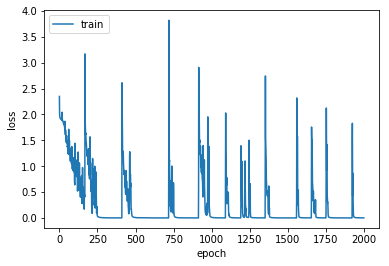

30/50 [=================>............] - ETA: 0sacc: 100.00%
('one step prediction : ', ['g8', 'e8', 'e4', 'f8', 'd8', 'd4', 'c8', 'd8', 'e8', 'f8', 'g8', 'g8', 'g4', 'g8', 'e8', 'e8', 'e8', 'f8', 'd8', 'd4', 'c8', 'e8', 'g8', 'g8', 'e8', 'e8', 'e4', 'd8', 'd8', 'd8', 'd8', 'd8', 'e8', 'f4', 'e8', 'e8', 'e8', 'e8', 'e8', 'f8', 'g4', 'g8', 'e8', 'e4', 'f8', 'd8', 'd4', 'c8', 'e8', 'g8', 'g8', 'e8', 'e8', 'e4'])
('full song prediction : ', ['g8', 'e8', 'e4', 'f8', 'd8', 'd4', 'c8', 'd8', 'e8', 'f8', 'g8', 'g8', 'g4', 'g8', 'e8', 'e8', 'e8', 'f8', 'd8', 'd4', 'c8', 'e8', 'g8', 'g8', 'e8', 'e8', 'e4', 'd8', 'd8', 'd8', 'd8', 'd8', 'e8', 'f4', 'e8', 'e8', 'e8', 'e8', 'e8', 'f8', 'g4', 'g8', 'e8', 'e4', 'f8', 'd8', 'd4', 'c8', 'e8', 'g8', 'g8', 'e8', 'e8', 'e4'])


In [6]:
# 0. 사용할 패키지 불러오기
import keras
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, LSTM
from keras.utils import np_utils

# 랜덤시드 고정시키기
np.random.seed(5)

# 손실 이력 클래스 정의
class LossHistory(keras.callbacks.Callback):
    def init(self):
        self.losses = []
        
    def on_epoch_end(self, batch, logs={}):
        self.losses.append(logs.get('loss'))

# 데이터셋 생성 함수
def seq2dataset(seq, window_size):
    dataset = []
    for i in range(len(seq)-window_size):
        subset = seq[i:(i+window_size+1)]
        dataset.append([code2idx[item] for item in subset])
    return np.array(dataset)        

# 1. 데이터 준비하기

# 코드 사전 정의

code2idx = {'c4':0, 'd4':1, 'e4':2, 'f4':3, 'g4':4, 'a4':5, 'b4':6,
            'c8':7, 'd8':8, 'e8':9, 'f8':10, 'g8':11, 'a8':12, 'b8':13}

idx2code = {0:'c4', 1:'d4', 2:'e4', 3:'f4', 4:'g4', 5:'a4', 6:'b4',
            7:'c8', 8:'d8', 9:'e8', 10:'f8', 11:'g8', 12:'a8', 13:'b8'}

# 시퀀스 데이터 정의

seq = ['g8', 'e8', 'e4', 'f8', 'd8', 'd4', 'c8', 'd8', 'e8', 'f8', 'g8', 'g8', 'g4',
       'g8', 'e8', 'e8', 'e8', 'f8', 'd8', 'd4', 'c8', 'e8', 'g8', 'g8', 'e8', 'e8', 'e4',
       'd8', 'd8', 'd8', 'd8', 'd8', 'e8', 'f4', 'e8', 'e8', 'e8', 'e8', 'e8', 'f8', 'g4',
       'g8', 'e8', 'e4', 'f8', 'd8', 'd4', 'c8', 'e8', 'g8', 'g8', 'e8', 'e8', 'e4']

# 2. 데이터셋 생성하기

dataset = seq2dataset(seq, window_size = 4)

print(dataset.shape)

# 입력(X)과 출력(Y) 변수로 분리하기
x_train = dataset[:,0:4]
y_train = dataset[:,4]

max_idx_value = 13

# 입력값 정규화 시키기
x_train = x_train / float(max_idx_value)

# 입력을 (샘플 수, 타임스텝, 특성 수)로 형태 변환
x_train = np.reshape(x_train, (50, 4, 1))

# 라벨값에 대한 one-hot 인코딩 수행
y_train = np_utils.to_categorical(y_train)

one_hot_vec_size = y_train.shape[1]

print("one hot encoding vector size is ", one_hot_vec_size)

# 3. 모델 구성하기
model = Sequential()
model.add(LSTM(128, batch_input_shape = (1, 4, 1), stateful=True))
model.add(Dense(one_hot_vec_size, activation='softmax'))
    
# 4. 모델 학습과정 설정하기
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# 5. 모델 학습시키기
num_epochs = 2000

history = LossHistory() # 손실 이력 객체 생성

history.init()

for epoch_idx in range(num_epochs):
    print ('epochs : ' + str(epoch_idx) )
    model.fit(x_train, y_train, epochs=1, batch_size=1, verbose=2, shuffle=False, callbacks=[history]) # 50 is X.shape[0]
    model.reset_states()
    
# 6. 학습과정 살펴보기
%matplotlib inline
import matplotlib.pyplot as plt

plt.plot(history.losses)
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train'], loc='upper left')
plt.show()

# 7. 모델 평가하기
scores = model.evaluate(x_train, y_train, batch_size=1)
print("%s: %.2f%%" %(model.metrics_names[1], scores[1]*100))
model.reset_states()

# 8. 모델 사용하기

pred_count = 50 # 최대 예측 개수 정의

# 한 스텝 예측

seq_out = ['g8', 'e8', 'e4', 'f8']
pred_out = model.predict(x_train, batch_size=1)

for i in range(pred_count):
    idx = np.argmax(pred_out[i]) # one-hot 인코딩을 인덱스 값으로 변환
    seq_out.append(idx2code[idx]) # seq_out는 최종 악보이므로 인덱스 값을 코드로 변환하여 저장

model.reset_states()
    
print("one step prediction : ", seq_out)

# 곡 전체 예측

seq_in = ['g8', 'e8', 'e4', 'f8']
seq_out = seq_in
seq_in = [code2idx[it] / float(max_idx_value) for it in seq_in] # 코드를 인덱스값으로 변환

for i in range(pred_count):
    sample_in = np.array(seq_in)
    sample_in = np.reshape(sample_in, (1, 4, 1)) # 샘플 수, 타입스텝 수, 속성 수
    pred_out = model.predict(sample_in)
    idx = np.argmax(pred_out)
    seq_out.append(idx2code[idx])
    seq_in.append(idx / float(max_idx_value))
    seq_in.pop(0)

model.reset_states()
    
print("full song prediction : ", seq_out)

한 스텝 예측 결과와 곡 전체 예측 결과를 악보로 그려보았습니다. Stateful LSTM은 음표를 모두 맞추어서, 전체 곡 예측도 정확하게 했습니다.

![img](http://tykimos.github.io/warehouse/2017-4-9-RNN_Layer_Talk_Stateful_LSTM_song.png)

위 악보로 연주한 곡은 아래 링크에서 다운로드 받으실 수 있습니다.

* [http://tykimos.github.io/warehouse/2017-4-9-Stateful_LSTM_f1_one_step_prediction.mp3](http://tykimos.github.io/warehouse/2017-4-9-Stateful_LSTM_f1_one_step_prediction.mp3)
* [http://tykimos.github.io/warehouse/2017-4-9-Stateful_LSTM_f1_full_song_prediction.mp3](http://tykimos.github.io/warehouse/2017-4-9-Stateful_LSTM_f1_full_song_prediction.mp3)

### 입력 속성이 여러 개인 모델 구성

입력 속성이 여러 개인 경우에 대해서 알아보겠습니다. 예를 들어 '기온'라는 것을 예측하기 위해서 입력으로 '기온'뿐만아니라 '습도', '기압', '풍향', '풍속' 등 다양한 속성이 있을 수 있습니다. 상태유지 LSTM 모델에서 입력형태를 batch_input_shape = (배치사이즈, 타임스텝, 속성)으로 설정하는데, 마지막 인자를 통해 속성의 개수를 지정할 수 있습니다. '나비야' 예제에서는 현재 입력값이 'c4, e4, g8'등으로 되어 있는 데, 이를 음정과 음길이로 나누어서 2개의 속성으로 입력해보겠습니다. 즉 'c4'는 '(c, 4)'로 나누어서 입력하게 되는 것입니다. 이를 위해 데이터셋 만드는 함수를 아래와 같이 수정하였습니다.

In [ ]:
def code2features(code):
    features = []
    features.append(code2scale[code[0]]/float(max_scale_value))
    features.append(code2length[code[1]])
    return features

LSTM 모델 생성 시 batch_input_shape 인자의 마지막 값이 '1'에서 '2'로 수정되었습니다.

In [ ]:
model = Sequential()
model.add(LSTM(128, batch_input_shape = (1, 4, 2), stateful=True))
model.add(Dense(one_hot_vec_size, activation='softmax'))

아래 그림을 보시면 입력이 두 개로 나누어짐을 보실 수 있습니다. 이 방식은 'c8'이니 'd4'처럼 코드 자체를 학습하는 것이 아니라 음정과 음길이를 나누어서 학습하는 효과를 볼 수 있습니다. 사람이 악보를 읽을 때도 이 둘은 나누어서 인지를 하니 좀 더 사람에 가까운 학습이라고 보실 수 있습니다.

![img](http://tykimos.github.io/warehouse/2017-4-9-RNN_Layer_Talk_train_stateful_LSTM_features.png)

전체 소스는 다음과 같습니다.

('one hot encoding vector size is ', 12)
epochs : 0
Epoch 1/1
1s - loss: 2.3099 - acc: 0.1400
epochs : 1
Epoch 1/1
0s - loss: 2.0182 - acc: 0.3400
epochs : 2
Epoch 1/1
0s - loss: 1.9620 - acc: 0.3400
epochs : 3
Epoch 1/1
0s - loss: 1.9460 - acc: 0.3400
epochs : 4
Epoch 1/1
0s - loss: 1.9356 - acc: 0.3400
epochs : 5
Epoch 1/1
0s - loss: 1.9280 - acc: 0.3400
epochs : 6
Epoch 1/1
0s - loss: 1.9218 - acc: 0.3400
epochs : 7
Epoch 1/1
0s - loss: 1.9164 - acc: 0.3400
epochs : 8
Epoch 1/1
0s - loss: 1.9113 - acc: 0.3600
epochs : 9
Epoch 1/1
0s - loss: 1.9061 - acc: 0.3600
epochs : 10
Epoch 1/1
0s - loss: 1.9001 - acc: 0.3600
epochs : 11
Epoch 1/1
0s - loss: 1.8917 - acc: 0.3600
epochs : 12
Epoch 1/1
0s - loss: 1.8784 - acc: 0.3600
epochs : 13
Epoch 1/1
0s - loss: 1.8637 - acc: 0.3600
epochs : 14
Epoch 1/1
0s - loss: 1.8493 - acc: 0.3600
epochs : 15
Epoch 1/1
0s - loss: 1.8289 - acc: 0.3600
epochs : 16
Epoch 1/1
0s - loss: 1.8345 - acc: 0.3600
epochs : 17
Epoch 1/1
0s - loss: 1.7975 - acc: 0.34

0s - loss: 0.0011 - acc: 1.0000
epochs : 151
Epoch 1/1
0s - loss: 0.0011 - acc: 1.0000
epochs : 152
Epoch 1/1
0s - loss: 0.0010 - acc: 1.0000
epochs : 153
Epoch 1/1
0s - loss: 9.9646e-04 - acc: 1.0000
epochs : 154
Epoch 1/1
0s - loss: 9.6575e-04 - acc: 1.0000
epochs : 155
Epoch 1/1
0s - loss: 9.3231e-04 - acc: 1.0000
epochs : 156
Epoch 1/1
0s - loss: 9.0404e-04 - acc: 1.0000
epochs : 157
Epoch 1/1
0s - loss: 8.7705e-04 - acc: 1.0000
epochs : 158
Epoch 1/1
0s - loss: 8.4910e-04 - acc: 1.0000
epochs : 159
Epoch 1/1
0s - loss: 8.2701e-04 - acc: 1.0000
epochs : 160
Epoch 1/1
0s - loss: 7.9886e-04 - acc: 1.0000
epochs : 161
Epoch 1/1
0s - loss: 7.7513e-04 - acc: 1.0000
epochs : 162
Epoch 1/1
0s - loss: 7.4852e-04 - acc: 1.0000
epochs : 163
Epoch 1/1
0s - loss: 7.2888e-04 - acc: 1.0000
epochs : 164
Epoch 1/1
0s - loss: 7.0347e-04 - acc: 1.0000
epochs : 165
Epoch 1/1
0s - loss: 6.8425e-04 - acc: 1.0000
epochs : 166
Epoch 1/1
0s - loss: 6.6765e-04 - acc: 1.0000
epochs : 167
Epoch 1/1
0s - loss

0s - loss: 0.0013 - acc: 1.0000
epochs : 299
Epoch 1/1
0s - loss: 0.0013 - acc: 1.0000
epochs : 300
Epoch 1/1
0s - loss: 0.0012 - acc: 1.0000
epochs : 301
Epoch 1/1
0s - loss: 0.0012 - acc: 1.0000
epochs : 302
Epoch 1/1
0s - loss: 0.0011 - acc: 1.0000
epochs : 303
Epoch 1/1
0s - loss: 0.0011 - acc: 1.0000
epochs : 304
Epoch 1/1
0s - loss: 0.0011 - acc: 1.0000
epochs : 305
Epoch 1/1
0s - loss: 0.0010 - acc: 1.0000
epochs : 306
Epoch 1/1
0s - loss: 0.0010 - acc: 1.0000
epochs : 307
Epoch 1/1
0s - loss: 9.8357e-04 - acc: 1.0000
epochs : 308
Epoch 1/1
0s - loss: 9.5430e-04 - acc: 1.0000
epochs : 309
Epoch 1/1
0s - loss: 9.2654e-04 - acc: 1.0000
epochs : 310
Epoch 1/1
0s - loss: 9.0093e-04 - acc: 1.0000
epochs : 311
Epoch 1/1
0s - loss: 8.7542e-04 - acc: 1.0000
epochs : 312
Epoch 1/1
0s - loss: 8.5071e-04 - acc: 1.0000
epochs : 313
Epoch 1/1
0s - loss: 8.2654e-04 - acc: 1.0000
epochs : 314
Epoch 1/1
0s - loss: 8.0355e-04 - acc: 1.0000
epochs : 315
Epoch 1/1
0s - loss: 7.8116e-04 - acc: 1.00

0s - loss: 0.0109 - acc: 1.0000
epochs : 440
Epoch 1/1
0s - loss: 0.0106 - acc: 1.0000
epochs : 441
Epoch 1/1
0s - loss: 0.0103 - acc: 1.0000
epochs : 442
Epoch 1/1
0s - loss: 0.0180 - acc: 1.0000
epochs : 443
Epoch 1/1
0s - loss: 0.0249 - acc: 1.0000
epochs : 444
Epoch 1/1
0s - loss: 0.1238 - acc: 0.9400
epochs : 445
Epoch 1/1
0s - loss: 0.0776 - acc: 0.9800
epochs : 446
Epoch 1/1
0s - loss: 0.3269 - acc: 0.8800
epochs : 447
Epoch 1/1
0s - loss: 0.1872 - acc: 0.9600
epochs : 448
Epoch 1/1
0s - loss: 0.6012 - acc: 0.8200
epochs : 449
Epoch 1/1
0s - loss: 0.1822 - acc: 0.9600
epochs : 450
Epoch 1/1
0s - loss: 0.1114 - acc: 0.9600
epochs : 451
Epoch 1/1
0s - loss: 0.1559 - acc: 0.9600
epochs : 452
Epoch 1/1
0s - loss: 0.2315 - acc: 0.9200
epochs : 453
Epoch 1/1
0s - loss: 0.4349 - acc: 0.7800
epochs : 454
Epoch 1/1
0s - loss: 0.4282 - acc: 0.8800
epochs : 455
Epoch 1/1
0s - loss: 0.1962 - acc: 0.9400
epochs : 456
Epoch 1/1
0s - loss: 0.4174 - acc: 0.8400
epochs : 457
Epoch 1/1
0s - loss:

0s - loss: 1.2433e-04 - acc: 1.0000
epochs : 584
Epoch 1/1
0s - loss: 1.2221e-04 - acc: 1.0000
epochs : 585
Epoch 1/1
0s - loss: 1.2045e-04 - acc: 1.0000
epochs : 586
Epoch 1/1
0s - loss: 1.1864e-04 - acc: 1.0000
epochs : 587
Epoch 1/1
0s - loss: 1.1699e-04 - acc: 1.0000
epochs : 588
Epoch 1/1
0s - loss: 1.1529e-04 - acc: 1.0000
epochs : 589
Epoch 1/1
0s - loss: 1.1353e-04 - acc: 1.0000
epochs : 590
Epoch 1/1
0s - loss: 1.1162e-04 - acc: 1.0000
epochs : 591
Epoch 1/1
0s - loss: 1.0979e-04 - acc: 1.0000
epochs : 592
Epoch 1/1
0s - loss: 1.0769e-04 - acc: 1.0000
epochs : 593
Epoch 1/1
0s - loss: 1.0542e-04 - acc: 1.0000
epochs : 594
Epoch 1/1
0s - loss: 1.0301e-04 - acc: 1.0000
epochs : 595
Epoch 1/1
0s - loss: 1.0034e-04 - acc: 1.0000
epochs : 596
Epoch 1/1
0s - loss: 9.7795e-05 - acc: 1.0000
epochs : 597
Epoch 1/1
0s - loss: 9.4943e-05 - acc: 1.0000
epochs : 598
Epoch 1/1
0s - loss: 9.2223e-05 - acc: 1.0000
epochs : 599
Epoch 1/1
0s - loss: 8.9379e-05 - acc: 1.0000
epochs : 600
Epoch 1

0s - loss: 3.9196e-06 - acc: 1.0000
epochs : 723
Epoch 1/1
0s - loss: 4.0114e-06 - acc: 1.0000
epochs : 724
Epoch 1/1
0s - loss: 3.5727e-06 - acc: 1.0000
epochs : 725
Epoch 1/1
0s - loss: 3.5310e-06 - acc: 1.0000
epochs : 726
Epoch 1/1
0s - loss: 3.4785e-06 - acc: 1.0000
epochs : 727
Epoch 1/1
0s - loss: 3.3975e-06 - acc: 1.0000
epochs : 728
Epoch 1/1
0s - loss: 3.2795e-06 - acc: 1.0000
epochs : 729
Epoch 1/1
0s - loss: 3.2294e-06 - acc: 1.0000
epochs : 730
Epoch 1/1
0s - loss: 3.1304e-06 - acc: 1.0000
epochs : 731
Epoch 1/1
0s - loss: 3.0899e-06 - acc: 1.0000
epochs : 732
Epoch 1/1
0s - loss: 2.9600e-06 - acc: 1.0000
epochs : 733
Epoch 1/1
0s - loss: 2.9862e-06 - acc: 1.0000
epochs : 734
Epoch 1/1
0s - loss: 2.7931e-06 - acc: 1.0000
epochs : 735
Epoch 1/1
0s - loss: 2.8932e-06 - acc: 1.0000
epochs : 736
Epoch 1/1
0s - loss: 2.6417e-06 - acc: 1.0000
epochs : 737
Epoch 1/1
0s - loss: 2.8932e-06 - acc: 1.0000
epochs : 738
Epoch 1/1
0s - loss: 7.3761e-05 - acc: 1.0000
epochs : 739
Epoch 1

0s - loss: 1.1073e-04 - acc: 1.0000
epochs : 866
Epoch 1/1
0s - loss: 1.0752e-04 - acc: 1.0000
epochs : 867
Epoch 1/1
0s - loss: 1.0435e-04 - acc: 1.0000
epochs : 868
Epoch 1/1
0s - loss: 1.0133e-04 - acc: 1.0000
epochs : 869
Epoch 1/1
0s - loss: 9.8363e-05 - acc: 1.0000
epochs : 870
Epoch 1/1
0s - loss: 9.5529e-05 - acc: 1.0000
epochs : 871
Epoch 1/1
0s - loss: 9.2805e-05 - acc: 1.0000
epochs : 872
Epoch 1/1
0s - loss: 9.0164e-05 - acc: 1.0000
epochs : 873
Epoch 1/1
0s - loss: 8.7556e-05 - acc: 1.0000
epochs : 874
Epoch 1/1
0s - loss: 8.4999e-05 - acc: 1.0000
epochs : 875
Epoch 1/1
0s - loss: 8.2527e-05 - acc: 1.0000
epochs : 876
Epoch 1/1
0s - loss: 8.0174e-05 - acc: 1.0000
epochs : 877
Epoch 1/1
0s - loss: 7.7953e-05 - acc: 1.0000
epochs : 878
Epoch 1/1
0s - loss: 7.5752e-05 - acc: 1.0000
epochs : 879
Epoch 1/1
0s - loss: 7.3674e-05 - acc: 1.0000
epochs : 880
Epoch 1/1
0s - loss: 7.1679e-05 - acc: 1.0000
epochs : 881
Epoch 1/1
0s - loss: 6.9748e-05 - acc: 1.0000
epochs : 882
Epoch 1

0s - loss: 3.4225e-06 - acc: 1.0000
epochs : 1005
Epoch 1/1
0s - loss: 3.3558e-06 - acc: 1.0000
epochs : 1006
Epoch 1/1
0s - loss: 3.2771e-06 - acc: 1.0000
epochs : 1007
Epoch 1/1
0s - loss: 3.2032e-06 - acc: 1.0000
epochs : 1008
Epoch 1/1
0s - loss: 3.1209e-06 - acc: 1.0000
epochs : 1009
Epoch 1/1
0s - loss: 3.0482e-06 - acc: 1.0000
epochs : 1010
Epoch 1/1
0s - loss: 2.9838e-06 - acc: 1.0000
epochs : 1011
Epoch 1/1
0s - loss: 2.9063e-06 - acc: 1.0000
epochs : 1012
Epoch 1/1
0s - loss: 2.8372e-06 - acc: 1.0000
epochs : 1013
Epoch 1/1
0s - loss: 2.7776e-06 - acc: 1.0000
epochs : 1014
Epoch 1/1
0s - loss: 2.7037e-06 - acc: 1.0000
epochs : 1015
Epoch 1/1
0s - loss: 2.6548e-06 - acc: 1.0000
epochs : 1016
Epoch 1/1
0s - loss: 2.5761e-06 - acc: 1.0000
epochs : 1017
Epoch 1/1
0s - loss: 2.5332e-06 - acc: 1.0000
epochs : 1018
Epoch 1/1
0s - loss: 2.4557e-06 - acc: 1.0000
epochs : 1019
Epoch 1/1
0s - loss: 2.4152e-06 - acc: 1.0000
epochs : 1020
Epoch 1/1
0s - loss: 2.3675e-06 - acc: 1.0000
epoc

0s - loss: 0.0014 - acc: 1.0000
epochs : 1147
Epoch 1/1
0s - loss: 0.0014 - acc: 1.0000
epochs : 1148
Epoch 1/1
0s - loss: 0.0013 - acc: 1.0000
epochs : 1149
Epoch 1/1
0s - loss: 0.0013 - acc: 1.0000
epochs : 1150
Epoch 1/1
0s - loss: 0.0012 - acc: 1.0000
epochs : 1151
Epoch 1/1
0s - loss: 0.0012 - acc: 1.0000
epochs : 1152
Epoch 1/1
0s - loss: 0.0011 - acc: 1.0000
epochs : 1153
Epoch 1/1
0s - loss: 0.0011 - acc: 1.0000
epochs : 1154
Epoch 1/1
0s - loss: 0.0010 - acc: 1.0000
epochs : 1155
Epoch 1/1
0s - loss: 0.0010 - acc: 1.0000
epochs : 1156
Epoch 1/1
0s - loss: 9.7718e-04 - acc: 1.0000
epochs : 1157
Epoch 1/1
0s - loss: 9.4314e-04 - acc: 1.0000
epochs : 1158
Epoch 1/1
0s - loss: 9.1098e-04 - acc: 1.0000
epochs : 1159
Epoch 1/1
0s - loss: 8.8035e-04 - acc: 1.0000
epochs : 1160
Epoch 1/1
0s - loss: 8.5160e-04 - acc: 1.0000
epochs : 1161
Epoch 1/1
0s - loss: 8.2450e-04 - acc: 1.0000
epochs : 1162
Epoch 1/1
0s - loss: 7.9872e-04 - acc: 1.0000
epochs : 1163
Epoch 1/1
0s - loss: 7.7408e-0

0s - loss: 2.4953e-05 - acc: 1.0000
epochs : 1285
Epoch 1/1
0s - loss: 2.4349e-05 - acc: 1.0000
epochs : 1286
Epoch 1/1
0s - loss: 2.3714e-05 - acc: 1.0000
epochs : 1287
Epoch 1/1
0s - loss: 2.3100e-05 - acc: 1.0000
epochs : 1288
Epoch 1/1
0s - loss: 2.2538e-05 - acc: 1.0000
epochs : 1289
Epoch 1/1
0s - loss: 2.1968e-05 - acc: 1.0000
epochs : 1290
Epoch 1/1
0s - loss: 2.1434e-05 - acc: 1.0000
epochs : 1291
Epoch 1/1
0s - loss: 2.0893e-05 - acc: 1.0000
epochs : 1292
Epoch 1/1
0s - loss: 2.0372e-05 - acc: 1.0000
epochs : 1293
Epoch 1/1
0s - loss: 1.9877e-05 - acc: 1.0000
epochs : 1294
Epoch 1/1
0s - loss: 1.9386e-05 - acc: 1.0000
epochs : 1295
Epoch 1/1
0s - loss: 1.8914e-05 - acc: 1.0000
epochs : 1296
Epoch 1/1
0s - loss: 1.8424e-05 - acc: 1.0000
epochs : 1297
Epoch 1/1
0s - loss: 1.7934e-05 - acc: 1.0000
epochs : 1298
Epoch 1/1
0s - loss: 1.7455e-05 - acc: 1.0000
epochs : 1299
Epoch 1/1
0s - loss: 1.7011e-05 - acc: 1.0000
epochs : 1300
Epoch 1/1
0s - loss: 1.6567e-05 - acc: 1.0000
epoc

0s - loss: 7.2360e-07 - acc: 1.0000
epochs : 1422
Epoch 1/1
0s - loss: 7.0930e-07 - acc: 1.0000
epochs : 1423
Epoch 1/1
0s - loss: 6.9499e-07 - acc: 1.0000
epochs : 1424
Epoch 1/1
0s - loss: 6.8426e-07 - acc: 1.0000
epochs : 1425
Epoch 1/1
0s - loss: 6.6876e-07 - acc: 1.0000
epochs : 1426
Epoch 1/1
0s - loss: 6.5327e-07 - acc: 1.0000
epochs : 1427
Epoch 1/1
0s - loss: 6.3062e-07 - acc: 1.0000
epochs : 1428
Epoch 1/1
0s - loss: 6.1512e-07 - acc: 1.0000
epochs : 1429
Epoch 1/1
0s - loss: 5.9843e-07 - acc: 1.0000
epochs : 1430
Epoch 1/1
0s - loss: 5.8293e-07 - acc: 1.0000
epochs : 1431
Epoch 1/1
0s - loss: 5.7101e-07 - acc: 1.0000
epochs : 1432
Epoch 1/1
0s - loss: 5.5552e-07 - acc: 1.0000
epochs : 1433
Epoch 1/1
0s - loss: 5.4479e-07 - acc: 1.0000
epochs : 1434
Epoch 1/1
0s - loss: 5.2691e-07 - acc: 1.0000
epochs : 1435
Epoch 1/1
0s - loss: 5.1498e-07 - acc: 1.0000
epochs : 1436
Epoch 1/1
0s - loss: 5.0902e-07 - acc: 1.0000
epochs : 1437
Epoch 1/1
0s - loss: 4.9472e-07 - acc: 1.0000
epoc

0s - loss: 5.4069e-04 - acc: 1.0000
epochs : 1562
Epoch 1/1
0s - loss: 5.1653e-04 - acc: 1.0000
epochs : 1563
Epoch 1/1
0s - loss: 4.9546e-04 - acc: 1.0000
epochs : 1564
Epoch 1/1
0s - loss: 4.7463e-04 - acc: 1.0000
epochs : 1565
Epoch 1/1
0s - loss: 4.5284e-04 - acc: 1.0000
epochs : 1566
Epoch 1/1
0s - loss: 4.3220e-04 - acc: 1.0000
epochs : 1567
Epoch 1/1
0s - loss: 4.0990e-04 - acc: 1.0000
epochs : 1568
Epoch 1/1
0s - loss: 3.9275e-04 - acc: 1.0000
epochs : 1569
Epoch 1/1
0s - loss: 3.7615e-04 - acc: 1.0000
epochs : 1570
Epoch 1/1
0s - loss: 3.5866e-04 - acc: 1.0000
epochs : 1571
Epoch 1/1
0s - loss: 3.4652e-04 - acc: 1.0000
epochs : 1572
Epoch 1/1
0s - loss: 3.3502e-04 - acc: 1.0000
epochs : 1573
Epoch 1/1
0s - loss: 3.2376e-04 - acc: 1.0000
epochs : 1574
Epoch 1/1
0s - loss: 3.0800e-04 - acc: 1.0000
epochs : 1575
Epoch 1/1
0s - loss: 2.9679e-04 - acc: 1.0000
epochs : 1576
Epoch 1/1
0s - loss: 2.8547e-04 - acc: 1.0000
epochs : 1577
Epoch 1/1
0s - loss: 2.7479e-04 - acc: 1.0000
epoc

0s - loss: 0.0048 - acc: 1.0000
epochs : 1700
Epoch 1/1
0s - loss: 0.0044 - acc: 1.0000
epochs : 1701
Epoch 1/1
0s - loss: 0.0041 - acc: 1.0000
epochs : 1702
Epoch 1/1
0s - loss: 0.0038 - acc: 1.0000
epochs : 1703
Epoch 1/1
0s - loss: 0.0036 - acc: 1.0000
epochs : 1704
Epoch 1/1
0s - loss: 0.0034 - acc: 1.0000
epochs : 1705
Epoch 1/1
0s - loss: 0.0032 - acc: 1.0000
epochs : 1706
Epoch 1/1
0s - loss: 0.0030 - acc: 1.0000
epochs : 1707
Epoch 1/1
0s - loss: 0.0028 - acc: 1.0000
epochs : 1708
Epoch 1/1
0s - loss: 0.0027 - acc: 1.0000
epochs : 1709
Epoch 1/1
0s - loss: 0.0025 - acc: 1.0000
epochs : 1710
Epoch 1/1
0s - loss: 0.0024 - acc: 1.0000
epochs : 1711
Epoch 1/1
0s - loss: 0.0023 - acc: 1.0000
epochs : 1712
Epoch 1/1
0s - loss: 0.0022 - acc: 1.0000
epochs : 1713
Epoch 1/1
0s - loss: 0.0021 - acc: 1.0000
epochs : 1714
Epoch 1/1
0s - loss: 0.0020 - acc: 1.0000
epochs : 1715
Epoch 1/1
0s - loss: 0.0019 - acc: 1.0000
epochs : 1716
Epoch 1/1
0s - loss: 0.0018 - acc: 1.0000
epochs : 1717
Ep

0s - loss: 3.4895e-05 - acc: 1.0000
epochs : 1839
Epoch 1/1
0s - loss: 3.4224e-05 - acc: 1.0000
epochs : 1840
Epoch 1/1
0s - loss: 3.3579e-05 - acc: 1.0000
epochs : 1841
Epoch 1/1
0s - loss: 3.2531e-05 - acc: 1.0000
epochs : 1842
Epoch 1/1
0s - loss: 3.1507e-05 - acc: 1.0000
epochs : 1843
Epoch 1/1
0s - loss: 3.0562e-05 - acc: 1.0000
epochs : 1844
Epoch 1/1
0s - loss: 2.9707e-05 - acc: 1.0000
epochs : 1845
Epoch 1/1
0s - loss: 2.9006e-05 - acc: 1.0000
epochs : 1846
Epoch 1/1
0s - loss: 2.8305e-05 - acc: 1.0000
epochs : 1847
Epoch 1/1
0s - loss: 2.7632e-05 - acc: 1.0000
epochs : 1848
Epoch 1/1
0s - loss: 2.6985e-05 - acc: 1.0000
epochs : 1849
Epoch 1/1
0s - loss: 2.6340e-05 - acc: 1.0000
epochs : 1850
Epoch 1/1
0s - loss: 2.5783e-05 - acc: 1.0000
epochs : 1851
Epoch 1/1
0s - loss: 2.5278e-05 - acc: 1.0000
epochs : 1852
Epoch 1/1
0s - loss: 2.4794e-05 - acc: 1.0000
epochs : 1853
Epoch 1/1
0s - loss: 2.4404e-05 - acc: 1.0000
epochs : 1854
Epoch 1/1
0s - loss: 2.3920e-05 - acc: 1.0000
epoc

0s - loss: 2.8625e-04 - acc: 1.0000
epochs : 1979
Epoch 1/1
0s - loss: 2.7766e-04 - acc: 1.0000
epochs : 1980
Epoch 1/1
0s - loss: 2.6948e-04 - acc: 1.0000
epochs : 1981
Epoch 1/1
0s - loss: 2.6166e-04 - acc: 1.0000
epochs : 1982
Epoch 1/1
0s - loss: 2.5419e-04 - acc: 1.0000
epochs : 1983
Epoch 1/1
0s - loss: 2.4701e-04 - acc: 1.0000
epochs : 1984
Epoch 1/1
0s - loss: 2.3990e-04 - acc: 1.0000
epochs : 1985
Epoch 1/1
0s - loss: 2.3333e-04 - acc: 1.0000
epochs : 1986
Epoch 1/1
0s - loss: 2.2709e-04 - acc: 1.0000
epochs : 1987
Epoch 1/1
0s - loss: 2.2099e-04 - acc: 1.0000
epochs : 1988
Epoch 1/1
0s - loss: 2.1531e-04 - acc: 1.0000
epochs : 1989
Epoch 1/1
0s - loss: 2.0991e-04 - acc: 1.0000
epochs : 1990
Epoch 1/1
0s - loss: 2.0499e-04 - acc: 1.0000
epochs : 1991
Epoch 1/1
0s - loss: 2.0001e-04 - acc: 1.0000
epochs : 1992
Epoch 1/1
0s - loss: 1.9515e-04 - acc: 1.0000
epochs : 1993
Epoch 1/1
0s - loss: 1.9052e-04 - acc: 1.0000
epochs : 1994
Epoch 1/1
0s - loss: 1.8616e-04 - acc: 1.0000
epoc

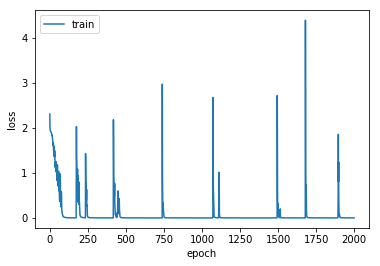

25/50 [==============>...............] - ETA: 0s acc: 100.00%
('one step prediction : ', ['g8', 'e8', 'e4', 'f8', 'd8', 'd4', 'c8', 'd8', 'e8', 'f8', 'g8', 'g8', 'g4', 'g8', 'e8', 'e8', 'e8', 'f8', 'd8', 'd4', 'c8', 'e8', 'g8', 'g8', 'e8', 'e8', 'e4', 'd8', 'd8', 'd8', 'd8', 'd8', 'e8', 'f4', 'e8', 'e8', 'e8', 'e8', 'e8', 'f8', 'g4', 'g8', 'e8', 'e4', 'f8', 'd8', 'd4', 'c8', 'e8', 'g8', 'g8', 'e8', 'e8', 'e4'])
('full song prediction : ', ['g8', 'e8', 'e4', 'f8', 'd8', 'd4', 'c8', 'd8', 'e8', 'f8', 'g8', 'g8', 'g4', 'g8', 'e8', 'e8', 'e8', 'f8', 'd8', 'd4', 'c8', 'e8', 'g8', 'g8', 'e8', 'e8', 'e4', 'd8', 'd8', 'd8', 'd8', 'd8', 'e8', 'f4', 'e8', 'e8', 'e8', 'e8', 'e8', 'f8', 'g4', 'g8', 'e8', 'e4', 'f8', 'd8', 'd4', 'c8', 'e8', 'g8', 'g8', 'e8', 'e8', 'e4'])


In [7]:
# 0. 사용할 패키지 불러오기
import keras
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, LSTM
from keras.utils import np_utils

# 랜덤시드 고정시키기
np.random.seed(5)

# 손실 이력 클래스 정의
class LossHistory(keras.callbacks.Callback):
    def init(self):
        self.losses = []
        
    def on_epoch_end(self, batch, logs={}):
        self.losses.append(logs.get('loss'))

# 데이터셋 생성 함수
def seq2dataset(seq, window_size):
    dataset_X = []
    dataset_Y = []
    
    for i in range(len(seq)-window_size):
        
        subset = seq[i:(i+window_size+1)]
        
        for si in range(len(subset)-1):
            features = code2features(subset[si])            
            dataset_X.append(features)

        dataset_Y.append([code2idx[subset[window_size]]])
        
    return np.array(dataset_X), np.array(dataset_Y)

# 속성 변환 함수
def code2features(code):
    features = []
    features.append(code2scale[code[0]]/float(max_scale_value))
    features.append(code2length[code[1]])
    return features

# 1. 데이터 준비하기

# 코드 사전 정의

code2scale = {'c':0, 'd':1, 'e':2, 'f':3, 'g':4, 'a':5, 'b':6}
code2length = {'4':0, '8':1}

code2idx = {'c4':0, 'd4':1, 'e4':2, 'f4':3, 'g4':4, 'a4':5, 'b4':6,
            'c8':7, 'd8':8, 'e8':9, 'f8':10, 'g8':11, 'a8':12, 'b8':13}

idx2code = {0:'c4', 1:'d4', 2:'e4', 3:'f4', 4:'g4', 5:'a4', 6:'b4',
            7:'c8', 8:'d8', 9:'e8', 10:'f8', 11:'g8', 12:'a8', 13:'b8'}

max_scale_value = 6.0
    
# 시퀀스 데이터 정의
seq = ['g8', 'e8', 'e4', 'f8', 'd8', 'd4', 'c8', 'd8', 'e8', 'f8', 'g8', 'g8', 'g4',
       'g8', 'e8', 'e8', 'e8', 'f8', 'd8', 'd4', 'c8', 'e8', 'g8', 'g8', 'e8', 'e8', 'e4',
       'd8', 'd8', 'd8', 'd8', 'd8', 'e8', 'f4', 'e8', 'e8', 'e8', 'e8', 'e8', 'f8', 'g4',
       'g8', 'e8', 'e4', 'f8', 'd8', 'd4', 'c8', 'e8', 'g8', 'g8', 'e8', 'e8', 'e4']

# 2. 데이터셋 생성하기

x_train, y_train = seq2dataset(seq, window_size = 4)

# 입력을 (샘플 수, 타임스텝, 특성 수)로 형태 변환
x_train = np.reshape(x_train, (50, 4, 2))

# 라벨값에 대한 one-hot 인코딩 수행
y_train = np_utils.to_categorical(y_train)

one_hot_vec_size = y_train.shape[1]

print("one hot encoding vector size is ", one_hot_vec_size)

# 3. 모델 구성하기
model = Sequential()
model.add(LSTM(128, batch_input_shape = (1, 4, 2), stateful=True))
model.add(Dense(one_hot_vec_size, activation='softmax'))
    
# 4. 모델 학습과정 설정하기
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# 5. 모델 학습시키기
num_epochs = 2000

history = LossHistory() # 손실 이력 객체 생성
history.init()

for epoch_idx in range(num_epochs):
    print ('epochs : ' + str(epoch_idx) )
    model.fit(x_train, y_train, epochs=1, batch_size=1, verbose=2, shuffle=False, callbacks=[history]) # 50 is X.shape[0]
    model.reset_states()
    
# 6. 학습과정 살펴보기
%matplotlib inline
import matplotlib.pyplot as plt

plt.plot(history.losses)
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train'], loc='upper left')
plt.show()

# 7. 모델 평가하기
scores = model.evaluate(x_train, y_train, batch_size=1)
print("%s: %.2f%%" %(model.metrics_names[1], scores[1]*100))
model.reset_states()

# 8. 모델 사용하기

pred_count = 50 # 최대 예측 개수 정의

# 한 스텝 예측

seq_out = ['g8', 'e8', 'e4', 'f8']
pred_out = model.predict(x_train, batch_size=1)

for i in range(pred_count):
    idx = np.argmax(pred_out[i]) # one-hot 인코딩을 인덱스 값으로 변환
    seq_out.append(idx2code[idx]) # seq_out는 최종 악보이므로 인덱스 값을 코드로 변환하여 저장
    
print("one step prediction : ", seq_out)

model.reset_states()

# 곡 전체 예측

seq_in = ['g8', 'e8', 'e4', 'f8']
seq_out = seq_in

seq_in_featrues = []

for si in seq_in:
    features = code2features(si)
    seq_in_featrues.append(features)

for i in range(pred_count):
    sample_in = np.array(seq_in_featrues)
    sample_in = np.reshape(sample_in, (1, 4, 2)) # 샘플 수, 타입스텝 수, 속성 수
    pred_out = model.predict(sample_in)
    idx = np.argmax(pred_out)
    seq_out.append(idx2code[idx])
    
    features = code2features(idx2code[idx])
    seq_in_featrues.append(features)
    seq_in_featrues.pop(0)

model.reset_states()
    
print("full song prediction : ", seq_out)

수행결과는 곡 전체를 정확하게 예측을 했습니다.

![img](http://tykimos.github.io/warehouse/2017-4-9-RNN_Layer_Talk_Stateful_LSTM_features_song.png)

위 악보로 연주한 곡은 아래 링크에서 다운로드 받으실 수 있습니다.

* [http://tykimos.github.io/warehouse/2017-4-9-Stateful_LSTM_f2_one_step_prediction.mp3](http://tykimos.github.io/warehouse/2017-4-9-Stateful_LSTM_f2_one_step_prediction.mp3)
* [http://tykimos.github.io/warehouse/2017-4-9-Stateful_LSTM_f2_full_song_prediction.mp3](http://tykimos.github.io/warehouse/2017-4-9-Stateful_LSTM_f2_full_song_prediction.mp3)

---

### 요약

익숙한 노래인 "나비야"를 가지고 순한 신경망 모델에 학습시켜봤습니다. 순항 신경망 모델 중 가장 많이 사용되는 LSTM 모델에 대해서 알아보고, 주요 인자들이 어떤 특성을 가지고 있는 지도 살펴보았습니다. 앞서 살펴본 4가지 모델에 대해서 학습 손실값을 그래프로 표시해봤습니다. 다층퍼셉트론 모델 > 기본 LSTM 모델 > 상태유지 LSTM 모델 (1개 속성) > 상태유지 LSTM 모델 (2개 속성) 순으로 더 빨리 학습되는 것을 확인할 수 있습니다.

![img](http://tykimos.github.io/warehouse/2017-4-9-RNN_Layer_Talk_loss_history.png)

---

### 같이 보기

* [강좌 목차](https://tykimos.github.io/Keras/lecture/)
* 이전 : [순환 신경망 레이어 이야기](https://tykimos.github.io/Keras/2017/04/09/RNN_Getting_Started/)
* 다음 : [수치입력 수치예측 모델 레시피](https://tykimos.github.io/Keras/2017/08/13/Numerical_Prediction_Model_Recipe/)